In [852]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional, List, Tuple
from pprint import pprint
from tqdm import tqdm
import time
import datetime
from scipy import stats

from itertools import combinations, product

import missingno as msno
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import Ridge
from sklearn.feature_selection import SelectFromModel

from BorutaShap import BorutaShap
import category_encoders as ce

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, Pool, EFeaturesSelectionAlgorithm, EShapCalcType
import xgboost as xgb

import optuna
from optuna.samplers import TPESampler

from utils import *
import gc
gc.enable()

In [7]:
seed = 42
np.random.seed(seed)
np.set_printoptions(2)
pd.options.display.float_format = '{:.4f}'.format
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)

TARGET = 'price_doc'

In [577]:
train = pd.read_csv("train.csv")
macro = pd.read_csv("macro.csv")
test = pd.read_csv("test.csv")

In [11]:
train, test = check_duplicates_and_constants(train, test)

Initial train shape: (30471, 292)
Initial test shape: (7662, 291)
Duplicates in train: 0
Duplicates in test: 0
Final train shape: (30471, 292) , test shape: (7662, 291).


In [16]:
macro, _ = check_duplicates_and_constants(macro)

Initial train shape: (2484, 100)
Duplicates in train: 0
Final train shape: (2484, 100) 

In [13]:
check_missings(train)

Total NA-values = 261026


,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,preschool_quota,school_quota,hospital_beds_raion,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,metro_min_walk,metro_km_walk,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_avg,cafe_avg_price_2000,cafe_sum_3000_min_price_avg,cafe_sum_3000_max_price_avg,cafe_avg_price_3000,prom_part_5000,cafe_sum_5000_min_price_avg,cafe_sum_5000_max_price_avg,cafe_avg_price_5000
Total,6383,167,9572,9572,13605,9572,9572,13559,6688,6685,14441,4991,4991,4991,4991,4991,4991,4991,4991,4991,4991,4991,4991,4991,4991,4991,4991,25,25,25,25,25,13281,13281,13281,6524,6524,6524,4199,4199,4199,1725,1725,1725,991,991,991,178,297,297,297
Percent,20.9478,0.5481,31.4135,31.4135,44.6490,31.4135,31.4135,44.4980,21.9487,21.9389,47.3926,16.3795,16.3795,16.3795,16.3795,16.3795,16.3795,16.3795,16.3795,16.3795,16.3795,16.3795,16.3795,16.3795,16.3795,16.3795,16.3795,0.0820,0.0820,0.0820,0.0820,0.0820,43.5857,43.5857,43.5857,21.4105,21.4105,21.4105,13.7803,13.7803,13.7803,5.6611,5.6611,5.6611,3.2523,3.2523,3.2523,0.5842,0.9747,0.9747,0.9747
Types,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [17]:
check_missings(macro)

Total NA-values = 46658


,gdp_quart,gdp_quart_growth,cpi,ppi,gdp_deflator,balance_trade,balance_trade_growth,usdrub,eurrub,brent,net_capital_export,average_provision_of_build_contract_moscow,rts,micex,micex_rgbi_tr,micex_cbi_tr,deposits_growth,deposits_rate,mortgage_growth,grp,grp_growth,income_per_cap,real_dispos_income_per_cap_growth,salary,salary_growth,retail_trade_turnover,retail_trade_turnover_per_cap,retail_trade_turnover_growth,labor_force,unemployment,employment,invest_fixed_capital_per_cap,invest_fixed_assets,profitable_enterpr_share,unprofitable_enterpr_share,share_own_revenues,overdue_wages_per_cap,fin_res_per_cap,marriages_per_1000_cap,divorce_rate,construction_value,invest_fixed_assets_phys,pop_natural_increase,pop_migration,pop_total_inc,childbirth,mortality,housing_fund_sqm,lodging_sqm_per_cap,water_pipes_share,baths_share,sewerage_share,gas_share,hot_water_share,electric_stove_share,heating_share,old_house_share,average_life_exp,infant_mortarity_per_1000_cap,perinatal_mort_per_1000_cap,incidence_population,rent_price_4+room_bus,rent_price_3room_bus,rent_price_2room_bus,rent_price_1room_bus,rent_price_3room_eco,rent_price_2room_eco,rent_price_1room_eco,load_of_teachers_preschool_per_teacher,child_on_acc_pre_school,load_of_teachers_school_per_teacher,students_state_oneshift,modern_education_share,old_education_build_share,provision_doctors,provision_nurse,load_on_doctors,power_clinics,hospital_beds_available_per_cap,hospital_bed_occupancy_per_year,provision_retail_space_sqm,provision_retail_space_modern_sqm,turnover_catering_per_cap,theaters_viewers_per_1000_cap,seats_theather_rfmin_per_100000_cap,museum_visitis_per_100_cap,bandwidth_sports,population_reg_sports_share,students_reg_sports_share,apartment_build,apartment_fund_sqm
Total,90,90,31,31,365,31,90,3,3,3,396,365,10,10,10,1,31,414,365,658,1023,293,658,293,658,293,293,293,293,293,293,293,293,658,658,658,658,658,658,658,658,658,293,658,658,293,293,658,658,658,658,658,658,658,658,658,658,293,658,658,658,273,273,273,273,273,273,273,1023,658,293,658,1389,1389,658,293,293,658,1023,1023,1753,1754,293,1023,293,1023,658,1023,1023,658,658
Percent,3.6232,3.6232,1.2480,1.2480,14.6940,1.2480,3.6232,0.1208,0.1208,0.1208,15.9420,14.6940,0.4026,0.4026,0.4026,0.0403,1.2480,16.6667,14.6940,26.4895,41.1836,11.7955,26.4895,11.7955,26.4895,11.7955,11.7955,11.7955,11.7955,11.7955,11.7955,11.7955,11.7955,26.4895,26.4895,26.4895,26.4895,26.4895,26.4895,26.4895,26.4895,26.4895,11.7955,26.4895,26.4895,11.7955,11.7955,26.4895,26.4895,26.4895,26.4895,26.4895,26.4895,26.4895,26.4895,26.4895,26.4895,11.7955,26.4895,26.4895,26.4895,10.9903,10.9903,10.9903,10.9903,10.9903,10.9903,10.9903,41.1836,26.4895,11.7955,26.4895,55.9179,55.9179,26.4895,11.7955,11.7955,26.4895,41.1836,41.1836,70.5717,70.6119,11.7955,41.1836,11.7955,41.1836,26.4895,41.1836,41.1836,26.4895,26.4895
Types,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [19]:
train.id.nunique() == len(train)

True

In [20]:
test.loc[test.id.isin(train.id), 'id'].nunique() 

0

In [24]:
train.describe(include="object")

,timestamp,product_type,sub_area,culture_objects_top_25,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,water_1line,big_road1_1line,railroad_1line,ecology
count,30471,30471,30471,30471,30471,30471,30471,30471,30471,30471,30471,30471,30471,30471,30471,30471
unique,1161,2,146,2,2,2,2,2,2,2,2,2,2,2,2,5
top,2014-12-16,Investment,Poselenie Sosenskoe,no,no,no,no,no,no,no,no,no,no,no,no,poor
freq,160,19448,1776,28543,28817,28155,30175,19600,29335,27649,29608,27427,28134,29690,29578,8018


<AxesSubplot:>

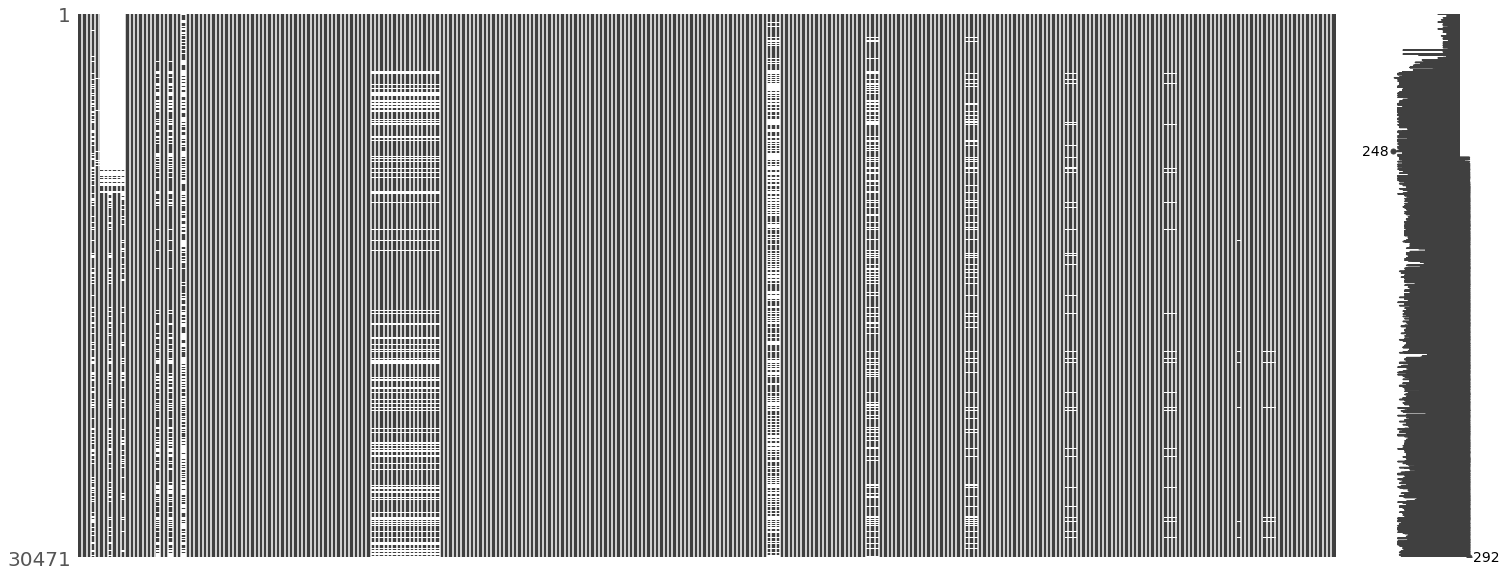

In [26]:
msno.matrix(train)

<AxesSubplot:>

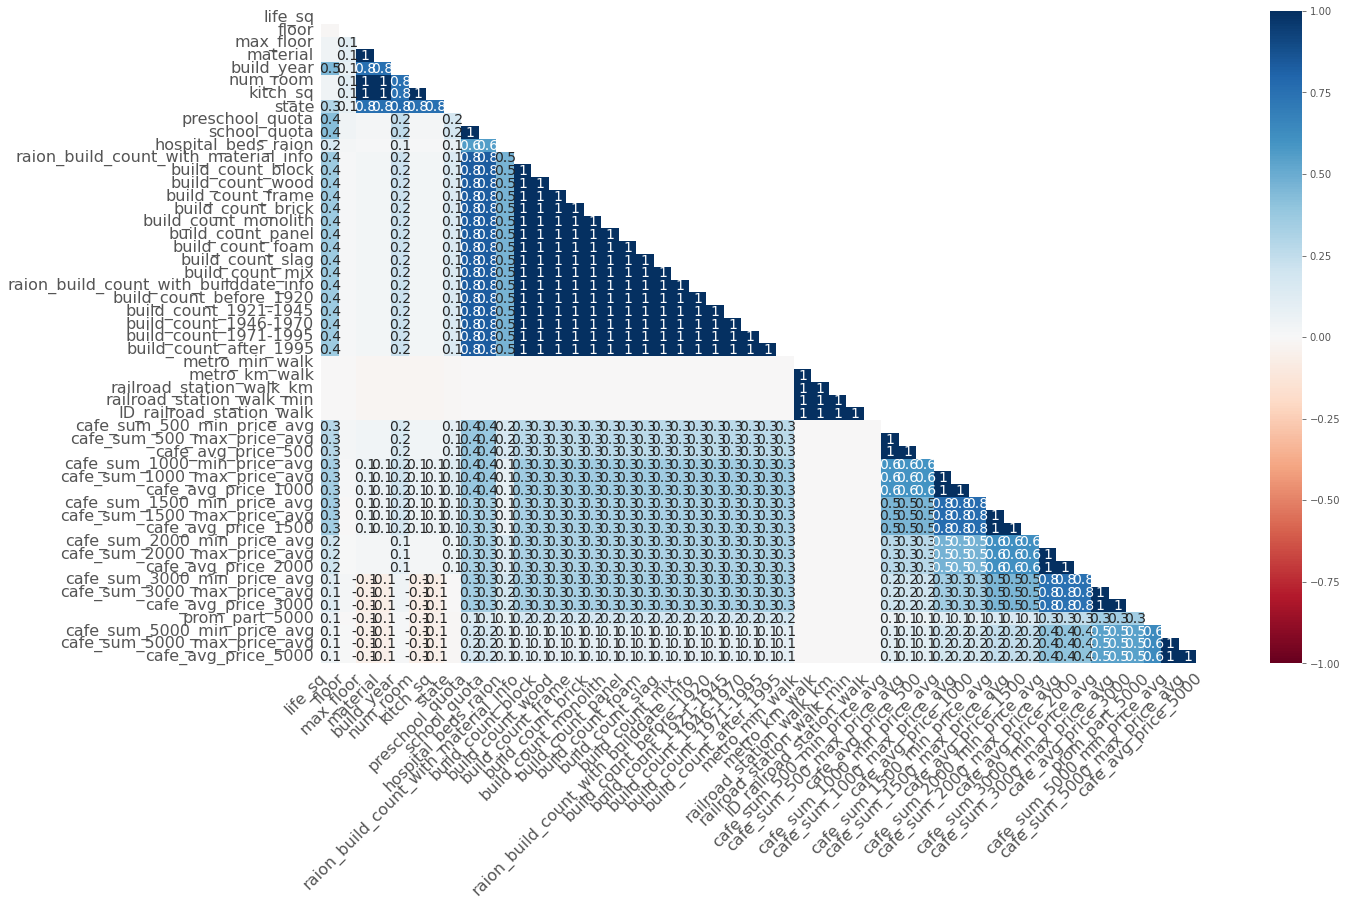

In [27]:
msno.heatmap(train)

In [28]:
train.head(2)

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_av

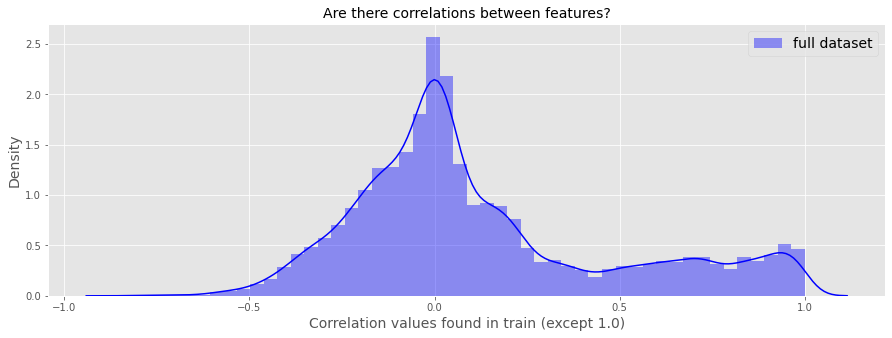

In [29]:
show_correlation_hist(train, columns=train.columns[2:])

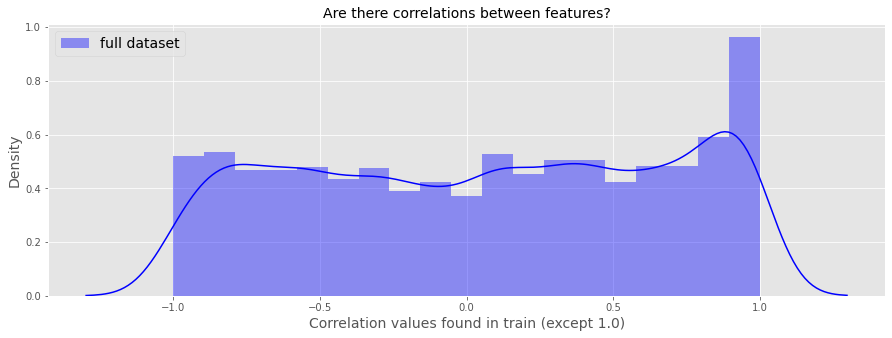

In [30]:
show_correlation_hist(macro, columns=macro.columns[1:])

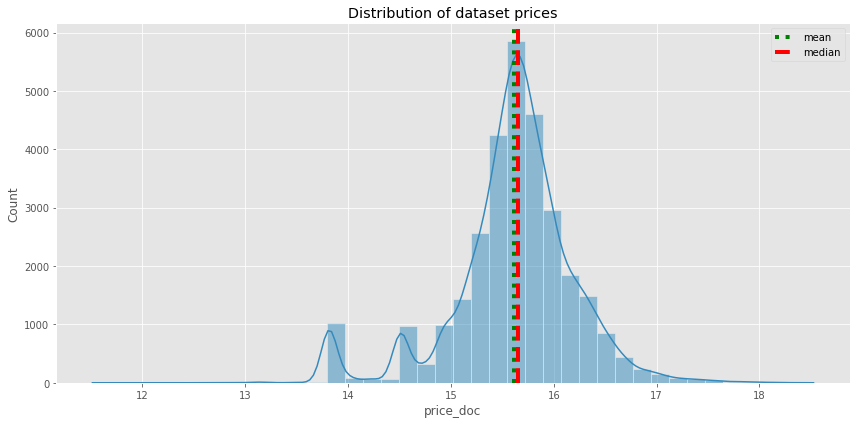

In [92]:
plt.figure(figsize = (12, 6))
func = lambda x: np.clip(np.log(x), 0,  np.percentile(train[TARGET], 99.7))

sns.histplot(train[TARGET].apply(func), bins=40, kde=True)
plt.axvline(train[TARGET].apply(func).mean(), label='mean', linestyle=':', color='green', linewidth=4)
plt.axvline(train[TARGET].apply(func).median(), label='median', linestyle='--', color='red', linewidth=4)

plt.title('Distribution of dataset prices')
plt.legend()
plt.tight_layout()
plt.show()
# this increases the chance to predict correct prices for most appartments but cannot predict high prices for vip 

<AxesSubplot:ylabel='price_doc'>

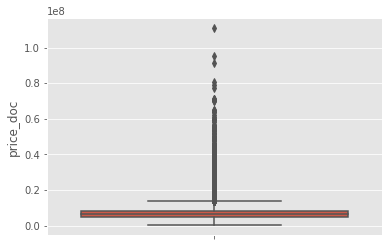

In [98]:
sns.boxplot(y=TARGET, data=train)

In [40]:
test.timestamp.describe()

count           7662
unique           274
top       2016-01-25
freq              80
Name: timestamp, dtype: object

In [41]:
train.timestamp.describe()

count          30471
unique          1161
top       2014-12-16
freq             160
Name: timestamp, dtype: object

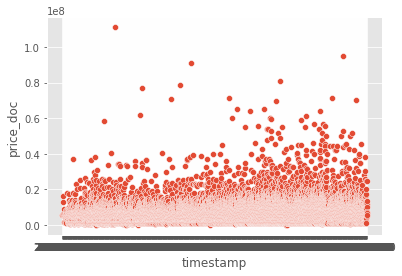

In [86]:
sns.scatterplot(x="timestamp", y=TARGET, data=train)
plt.show()
# split by time or ordinal?

In [48]:
train.describe()

,id,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25_raion,shopping_centers_raion,office_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road2_km,ID_big_road2,railroad_km,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_avg,cafe_avg_price_2000,cafe_count_2000_na_price,cafe_count_2000_price_500,cafe_count_2000_price_1000,cafe_count_2000_price_1500,cafe_count_2000_price_2500,cafe_count_2000_price_4000,cafe_count_2000_price_high,big_church_count_2000,church_count_2000,mosque_count_2000,leisure_c

In [78]:
for column in train.columns:
    if "ID_" in column:
        print(f"Feature {column}: {train[column].nunique()}")
# categories

Feature ID_metro: 223
Feature ID_railroad_station_walk: 133
Feature ID_railroad_station_avto: 133
Feature ID_big_road1: 48
Feature ID_big_road2: 58
Feature ID_railroad_terminal: 8
Feature ID_bus_terminal: 14


In [65]:
test.state.value_counts()

2.0000    2662
1.0000    2266
3.0000    1913
4.0000     127
Name: state, dtype: int64

In [49]:
train[TARGET].describe()

count       30471.0000
mean      7123035.2777
std       4780111.3296
min        100000.0000
25%       4740002.0000
50%       6274411.0000
75%       8300000.0000
max     111111112.0000
Name: price_doc, dtype: float64

**Check train/test distributions**

In [ ]:
# check dist train test
cat_cols = [col for col in train.columns if train[col].dtype in ["object", "category"]]
train[cat_cols] = train[cat_cols].astype("str").astype("category")
test[cat_cols] = test[cat_cols].astype("str").astype("category")
cat_cols.remove("timestamp")

cat_cols_ind = [i for i, col in enumerate(train.columns) if col in cat_cols]

In [143]:
x_inspect = pd.concat([train.drop([TARGET, "timestamp", "id"], axis=1), test.drop(["timestamp", "id"], axis=1)], axis=0)
y_inspect = np.hstack((np.zeros(train.shape[0]), np.ones(test.shape[0])))

params = {
    "iterations": 200, "depth": 3, "cat_features": cat_cols, "silent": True
}

fold = KFold(n_splits=5, random_state=seed, shuffle=True)
_, oof_preds = catboost_cross_validation(params, 
                                         x_inspect.reset_index(drop=True), 
                                         y_inspect, 
                                         cv=fold, 
                                         rounds=50,
                                         categorical=cat_cols,
                                        )

Mon Sep 12 13:13:11 2022, Cross-Validation, 38133 rows, 289 cols
Fold 1, Train score = 0.98107, Valid score = 0.97585
Fold 2, Train score = 0.98122, Valid score = 0.98129
Fold 3, Train score = 0.98103, Valid score = 0.97913
Fold 4, Train score = 0.98251, Valid score = 0.97456
Fold 5, Train score = 0.98050, Valid score = 0.97418
Train score by each fold: [0.98107, 0.98122, 0.98103, 0.98251, 0.9805]
Valid score by each fold: [0.97585, 0.98129, 0.97913, 0.97456, 0.97418]
Train mean score by each fold:0.98127 +/- 0.00067
Valid mean score by each fold:0.97700 +/- 0.00276
**************************************************
OOF-score: 0.97704


In [144]:
oof_preds_train = oof_preds[:train.shape[0]]
assert oof_preds_train.shape[0] == train.shape[0]

bins = pd.cut(
    oof_preds_train, bins=np.arange(0, 1.01, 0.1)
)
bins.value_counts().sort_index()
# not enough indices

(0.0, 0.1]    24690
(0.1, 0.2]     3752
(0.2, 0.3]     1098
(0.3, 0.4]      457
(0.4, 0.5]      229
(0.5, 0.6]      145
(0.6, 0.7]       66
(0.7, 0.8]       25
(0.8, 0.9]        7
(0.9, 1.0]        2
dtype: int64

In [145]:
split_model = CatBoostClassifier(**params).fit(x_inspect, y_inspect)

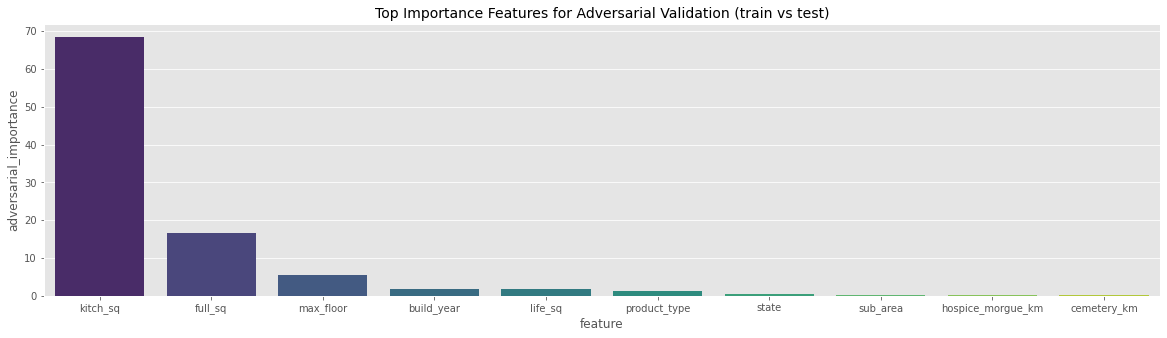

In [148]:
importance = pd.DataFrame({
    "feature": x_inspect.columns,
    "adversarial_importance": split_model.get_feature_importance()
})
importance = importance.sort_values(by="adversarial_importance", ascending=False)
importance = importance.head(n=10)

plt.figure(figsize=(20, 5))
sns.barplot(x=importance["feature"], y=importance["adversarial_importance"], palette="viridis")
plt.title("Top Importance Features for Adversarial Validation (train vs test)", size=14)
plt.show()

**simple baselines to check if random split is applicable**

In [207]:
train["timestamp"] = pd.to_datetime(train["timestamp"]).astype(np.int64) / 10**9
test["timestamp"] = pd.to_datetime(test["timestamp"]).astype(np.int64) / 10**9

In [169]:
train = train.sort_values("timestamp")
X, y = train.drop([TARGET, "id", "timestamp"], axis=1), train[TARGET]
x_train, x_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.3, random_state=seed)

In [208]:
# shuffled split
X, y = train.drop([TARGET, "id", "timestamp"], axis=1), train[TARGET]
x_train, x_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, random_state=seed)

In [218]:
cat = CatBoostRegressor(cat_features=cat_cols, 
                        silent=True,
                        eval_metric="MSLE",
                        loss_function="RMSE").fit(x_train, y_train)

In [219]:
train_preds = catboost.CatBoost.predict(cat, x_train, prediction_type="RawFormulaVal")
test_preds = catboost.CatBoost.predict(cat, x_test, prediction_type="RawFormulaVal")

In [220]:
rmsle(y_train, train_preds), rmsle(y_test, test_preds)

(0.4237304989228816, 0.4666563719007455)

In [221]:
test[cat_cols] = test[cat_cols].astype("str")
sub_preds = catboost.CatBoost.predict(cat, test.drop(["id", "timestamp"], axis=1), prediction_type="RawFormulaVal")

In [222]:
calculate_confidence_interval(create_bootstrap_metrics(y_test, test_preds, rmsle))  # not in CI

(0.448791924086052, 0.4824916028506408)

In [216]:
submission = pd.DataFrame(data={"id": test.id, TARGET: sub_preds})
submission.to_csv("submission.csv", index=False)

In [217]:
!kaggle competitions submit -c sberbank-russian-housing-market -f submission.csv -m "Message"

# naive baseline splitted by time
# Score: 0.32538
# Public score: 0.32017

# naive baseline splitted randomly
# Score: 0.31721
# Private score: 0.32275

# score not in CI, bad validation

Successfully submitted to Sberbank Russian Housing Market



  0%|          | 0.00/192k [00:00<?, ?B/s]
100%|##########| 192k/192k [00:02<00:00, 83.7kB/s]


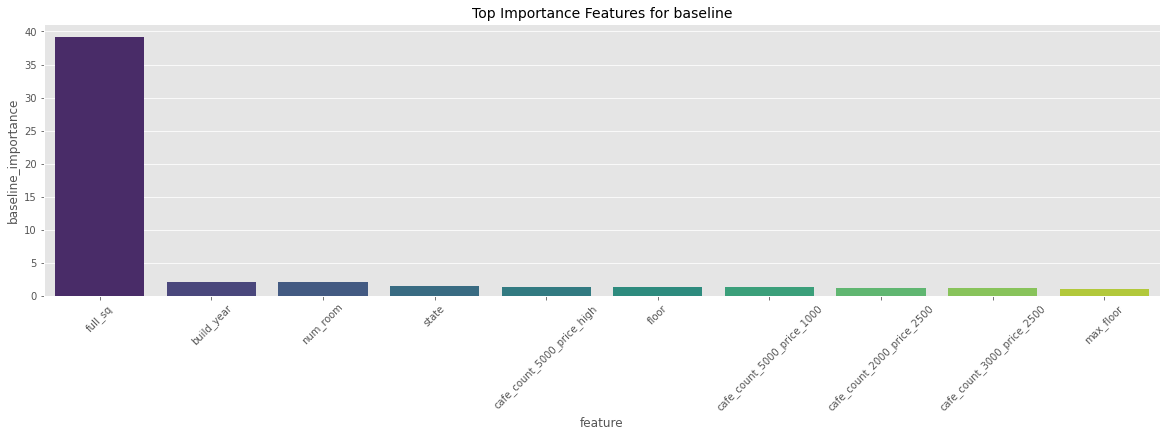

In [395]:
importance = pd.DataFrame({
    "feature": x_train.columns,
    "baseline_importance": cat.get_feature_importance()
})
importance = importance.sort_values(by="baseline_importance", ascending=False)
importance = importance.head(n=10)

plt.figure(figsize=(20, 5))
sns.barplot(x=importance["feature"], y=importance["baseline_importance"], palette="viridis")
plt.title("Top Importance Features for baseline", size=14)
plt.xticks(rotation=45)
plt.show()

In [229]:
cb_params = {
            "iterations": 2000,
            "learning_rate": 0.01,
            "loss_function": "RMSE",
            "eval_metric": "MSLE",
            "task_type": "CPU",
            "max_bin": 254,
            "silent": True,
            "depth": 6,
            "l2_leaf_reg": 100,
            "thread_count": -1,
            "random_seed": seed,
            "allow_writing_files": False,
            "subsample": 1, 
            "max_ctr_complexity": 4,
            "grow_policy": "SymmetricTree",
            "boosting_type": "Ordered",  
            "score_function": "Cosine", 
            "bootstrap_type": "MVS",  
            "bagging_temperature": 1, 
            "colsample_bylevel": 1,
            "use_best_model": True,
}

In [230]:
estimators_cat, oof_preds_cat = catboost_cross_validation(cb_params, 
                                                          X, 
                                                          y, 
                                                          cv=KFold(n_splits=5, random_state=seed, shuffle=True), 
                                                          rounds=50,
                                                          categorical=cat_cols)

gc.collect()

Mon Sep 12 17:40:26 2022, Cross-Validation, 30471 rows, 289 cols
Fold 1, Train score = 0.47861, Valid score = 0.47785
Fold 2, Train score = 0.47744, Valid score = 0.48052
Fold 3, Train score = 0.47876, Valid score = 0.47038
Fold 4, Train score = 0.47750, Valid score = 0.49441
Fold 5, Train score = 0.47973, Valid score = 0.48841
Train score by each fold: [0.47861, 0.47744, 0.47876, 0.4775, 0.47973]
Valid score by each fold: [0.47785, 0.48052, 0.47038, 0.49441, 0.48841]
Train mean score by each fold:0.47841 +/- 0.00086
Valid mean score by each fold:0.48231 +/- 0.00836
**************************************************
OOF-score: 0.48239


29100

**macro features**

In [196]:
macro.describe(include="object")

,timestamp,child_on_acc_pre_school,modern_education_share,old_education_build_share
count,2484,1826,1095,1095
unique,2484,5,3,3
top,2010-01-01,"7,311","90,92","23,14"
freq,1,366,365,365


In [195]:
macro.describe()

,oil_urals,gdp_quart,gdp_quart_growth,cpi,ppi,gdp_deflator,balance_trade,balance_trade_growth,usdrub,eurrub,brent,net_capital_export,gdp_annual,gdp_annual_growth,average_provision_of_build_contract,average_provision_of_build_contract_moscow,rts,micex,micex_rgbi_tr,micex_cbi_tr,deposits_value,deposits_growth,deposits_rate,mortgage_value,mortgage_growth,mortgage_rate,grp,grp_growth,income_per_cap,real_dispos_income_per_cap_growth,salary,salary_growth,fixed_basket,retail_trade_turnover,retail_trade_turnover_per_cap,retail_trade_turnover_growth,labor_force,unemployment,employment,invest_fixed_capital_per_cap,invest_fixed_assets,profitable_enterpr_share,unprofitable_enterpr_share,share_own_revenues,overdue_wages_per_cap,fin_res_per_cap,marriages_per_1000_cap,divorce_rate,construction_value,invest_fixed_assets_phys,pop_natural_increase,pop_migration,pop_total_inc,childbirth,mortality,housing_fund_sqm,lodging_sqm_per_cap,water_pipes_share,baths_share,sewerage_share,gas_share,hot_water_share,electric_stove_share,heating_share,old_house_share,average_life_exp,infant_mortarity_per_1000_cap,perinatal_mort_per_1000_cap,incidence_population,rent_price_4+room_bus,rent_price_3room_bus,rent_price_2room_bus,rent_price_1room_bus,rent_price_3room_eco,rent_price_2room_eco,rent_price_1room_eco,load_of_teachers_preschool_per_teacher,load_of_teachers_school_per_teacher,students_state_oneshift,provision_doctors,provision_nurse,load_on_doctors,power_clinics,hospital_beds_available_per_cap,hospital_bed_occupancy_per_year,provision_retail_space_sqm,provision_retail_space_modern_sqm,turnover_catering_per_cap,theaters_viewers_per_1000_cap,seats_theather_rfmin_per_100000_cap,museum_visitis_per_100_cap,bandwidth_sports,population_reg_sports_share,students_reg_sports_share,apartment_build,apartment_fund_sqm
count,2484.0000,2394.0000,2394.0000,2453.0000,2453.0000,2119.0000,2453.0000,2394.0000,2481.0000,2481.0000,2481.0000,2088.0000,2484.0000,2484.0000,2484.0000,2119.0000,2474.0000,2474.0000,2474.0000,2483.0000,2484.0000,2453.0000,2070.0000,2484.0000,2119.0000,2484.0000,1826.0000,1461.0000,2191.0000,1826.0000,2191.0000,1826.0000,2484.0000,2191.0000,2191.0000,2191.0000,2191.0000,2191.0000,2191.0000,2191.0000,2191.0000,1826.0000,1826.0000,1826.0000,1826.0000,1826.0000,1826.0000,1826.0000,1826.0000,1826.0000,2191.0000,1826.0000,1826.0000,2191.0000,2191.0000,1826.0000,1826.0000,1826.0000,1826.0000,1826.0000,1826.0000,1826.0000,1826.0000,1826.0000,1826.0000,2191.0000,1826.0000,1826.0000,1826.0000,2211.0000,2211.0000,2211.0000,2211.0000,2211.0000,2211.0000,2211.0000,1461.0000,2191.0000,1826.0000,1826.0000,2191.0000,2191.0000,1826.0000,1461.0000,1461.0000,731.0000,730.0000,2191.0000,1461.0000,2191.0000,1461.0000,1826.0000,1461.0000,1461.0000,1826.0000,1826.0000
mean,86.4672,16993.2301,1.5237,407.8084,480.2163,110.1223,15.3440,16.8467,40.7324,50.4448,88.1841,-0.0389,62557.0735,0.0051,5.7663,6.5614,1314.5398,1553.7973,129.0263,233.7290,15041696.6852,0.0139,6.2964,500798.0652,0.4323,12.6593,10722.9648,0.1129,51766.2389,-0.0034,52188.9331,0.1093,15331.4980,3767.9699,315.6448,100.6338,6818.9837,0.0149,0.7176,102647.8193,1229.2909,0.6914,0.3086,0.9488,51196.6090,200.7799,8.1198,3.7599,624322.8835,108.5535,1.1934,8.5602,9.6604,11.1584,9.9650,226.4025,19.0399,99.2398,99.0797,98.6396,43.8601,94.8797,54.8196,99.5399,0.3600,75.9282,6.8207,7.6074,691.3640,166.7545,95.2274,72.0501,52.8720,47.2997,38.8954,31.0024,808.7635,1455.1659,94.3367,55.2459,96.1668,7983.7157,171.5916,790.2813,294.7522,767.5363,480.5000,8691.9224,580.5154,0.4434,1245.5435,349902.5778,25.0686,67.8000,36282.4348,230615.0593
std,27.5287,3187.0745,2.8757,65.8960,70.2864,14.8184,3.8781,16.9887,15.0066,13.9059,26.9600,0.2744,14503.6796,0.0426,0.5367,0.4501,334.6049,180.7905,7.1015,35.5820,4762312.3386,0.0183,1.8982,394604.9807,0.4778,0.6560,1526.6625,0.0451,13310.7091,0.0473,9068.5590,0.0406,2789.1363,548.1686,38.9266,8.2071,229.1270,0.0034,0.0164,25659.1335,332.4774,0.0249,0.0249,0.0310,22888.8561,54.5216,0.2483,

**Feature EDA continue, Feature engineering**

In [239]:
pd.to_datetime(train["timestamp"]).dt.year.value_counts()

2014    13662
2013     7978
2012     4839
2015     3239
2011      753
Name: timestamp, dtype: int64

In [237]:
pd.to_datetime(test["timestamp"]).dt.year.value_counts()

2016    3983
2015    3679
Name: timestamp, dtype: int64

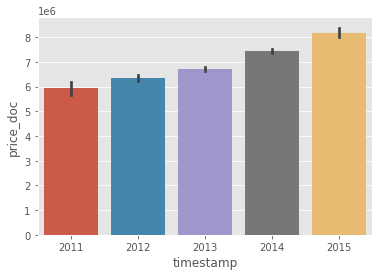

In [243]:
sns.barplot(x=pd.to_datetime(train["timestamp"]).dt.year, y=train[TARGET])
plt.show()

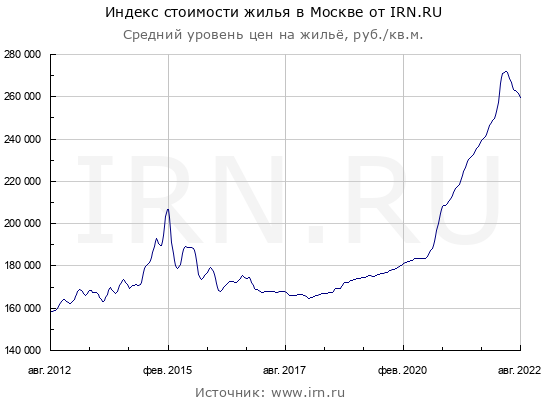

In [245]:
train.groupby(pd.to_datetime(train["timestamp"]).dt.year)[TARGET].mean()

timestamp
2011   5929668.1235
2012   6354435.1752
2013   6712149.6824
2014   7449467.8603
2015   8183913.5428
Name: price_doc, dtype: float64

<AxesSubplot:xlabel='life_sq'>

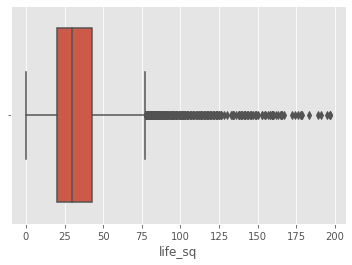

In [261]:
sns.boxplot(train.loc[train.life_sq < 200, 'life_sq'])

### clean & create

In [1153]:
train = pd.read_csv("train.csv")
macro = pd.read_csv("macro.csv")
test = pd.read_csv("test.csv")

# train = train[train[TARGET] != 111111112]
# train[TARGET] = np.clip(np.log(train[TARGET]), 0,  np.percentile(train[TARGET], 99.7))

df = pd.concat([train, test], axis=0)

df.loc[df["full_sq"] < 10, "full_sq"] = np.nan
df.loc[df["life_sq"] < 5, "life_sq"] = np.nan
df.loc[df["kitch_sq"] < 2, "kitch_sq"] = np.nan

df.loc[df["full_sq"] > 1000, "full_sq"] /= 100
df.loc[(df["full_sq"] > 210) & (df["life_sq"] / df["full_sq"] < 0.3), "full_sq"] /= 10
df.loc[df["full_sq"] > 210, "full_sq"] /= 10

df.loc[df["life_sq"] > 1000, "life_sq"] /= 100
df.loc[df["life_sq"] > 210, "life_sq"] /= 10

df.loc[df["life_sq"] > df["full_sq"], "life_sq"] = np.nan
df.loc[df["kitch_sq"] > df["full_sq"], "kitch_sq"] = np.nan
df.loc[df["kitch_sq"] > df["life_sq"], "kitch_sq"] = np.nan

df.loc[df["build_year"] > 2022, "build_year"] = np.nan
df.loc[df["build_year"] < 1800, "build_year"] = np.nan

df.loc[df["state"] > 4, "state"] = np.nan

df.loc[df["num_room"] == 0, "num_room"] = np.nan
df.loc[(df["num_room"] > 6) & (df["full_sq"] < 100), "num_room"] = np.nan

df.loc[df["floor"] == 0, "floor"] = np.nan
df.loc[df["max_floor"] == 0, "max_floor"] = np.nan

df.loc[df["floor"] > df["max_floor"], "max_floor"] = df.loc[df["floor"] > df["max_floor"], "floor"]
gc.collect()

3790

In [1154]:
# df = pd.merge(df, macro, on="timestamp", how="left")

df["timestamp"] = pd.to_datetime(df["timestamp"])
df["year_month"] = (df["timestamp"].dt.year*100 + df["timestamp"].dt.month).astype("str")
df["year_week"] = (df["timestamp"].dt.year*100 + df["timestamp"].dt.weekofyear).astype("str")

df["year"] = df["timestamp"].dt.year.astype("str")
df["month"] = df["timestamp"].dt.month.astype("str")
df["year_week"] = df["timestamp"].dt.weekofyear.astype("str")
df["weekday"] = df["timestamp"].dt.weekday.astype("str")

In [1155]:
train, test = df[~df[TARGET].isna()], df[df[TARGET].isna()]

train = train[(train["price_doc"] / train["full_sq"] <= 600000)]
train = train[(train["price_doc"] / train["full_sq"] >= 10000)]

In [1156]:
rate_2015_q2 = 1
rate_2015_q1 = rate_2015_q2 / 0.9932
rate_2014_q4 = rate_2015_q1 / 1.0112
rate_2014_q3 = rate_2014_q4 / 1.0169
rate_2014_q2 = rate_2014_q3 / 1.0086
rate_2014_q1 = rate_2014_q2 / 1.0126
rate_2013_q4 = rate_2014_q1 / 0.9902
rate_2013_q3 = rate_2013_q4 / 1.0041
rate_2013_q2 = rate_2013_q3 / 1.0044
rate_2013_q1 = rate_2013_q2 / 1.0104 
rate_2012_q4 = rate_2013_q1 / 0.9832
rate_2012_q3 = rate_2012_q4 / 1.0277
rate_2012_q2 = rate_2012_q3 / 1.0279
rate_2012_q1 = rate_2012_q2 / 1.0279
rate_2011_q4 = rate_2012_q1 / 1.076
rate_2011_q3 = rate_2011_q4 / 1.0236
rate_2011_q2 = rate_2011_q3 / 1
rate_2011_q1 = rate_2011_q2 / 1.011

In [1157]:
train['average_q_price'] = 1

train_2015_q2_index = train.loc[train['timestamp'].dt.year == 2015].loc[train['timestamp'].dt.month >= 4].loc[train['timestamp'].dt.month < 7].index
train.loc[train_2015_q2_index, 'average_q_price'] = rate_2015_q2

train_2015_q1_index = train.loc[train['timestamp'].dt.year == 2015].loc[train['timestamp'].dt.month >= 1].loc[train['timestamp'].dt.month < 4].index
train.loc[train_2015_q1_index, 'average_q_price'] = rate_2015_q1


# train 2014
train_2014_q4_index = train.loc[train['timestamp'].dt.year == 2014].loc[train['timestamp'].dt.month >= 10].loc[train['timestamp'].dt.month <= 12].index
train.loc[train_2014_q4_index, 'average_q_price'] = rate_2014_q4

train_2014_q3_index = train.loc[train['timestamp'].dt.year == 2014].loc[train['timestamp'].dt.month >= 7].loc[train['timestamp'].dt.month < 10].index
train.loc[train_2014_q3_index, 'average_q_price'] = rate_2014_q3

train_2014_q2_index = train.loc[train['timestamp'].dt.year == 2014].loc[train['timestamp'].dt.month >= 4].loc[train['timestamp'].dt.month < 7].index
train.loc[train_2014_q2_index, 'average_q_price'] = rate_2014_q2

train_2014_q1_index = train.loc[train['timestamp'].dt.year == 2014].loc[train['timestamp'].dt.month >= 1].loc[train['timestamp'].dt.month < 4].index
train.loc[train_2014_q1_index, 'average_q_price'] = rate_2014_q1


# train 2013
train_2013_q4_index = train.loc[train['timestamp'].dt.year == 2013].loc[train['timestamp'].dt.month >= 10].loc[train['timestamp'].dt.month <= 12].index
train.loc[train_2013_q4_index, 'average_q_price'] = rate_2013_q4

train_2013_q3_index = train.loc[train['timestamp'].dt.year == 2013].loc[train['timestamp'].dt.month >= 7].loc[train['timestamp'].dt.month < 10].index
train.loc[train_2013_q3_index, 'average_q_price'] = rate_2013_q3

train_2013_q2_index = train.loc[train['timestamp'].dt.year == 2013].loc[train['timestamp'].dt.month >= 4].loc[train['timestamp'].dt.month < 7].index
train.loc[train_2013_q2_index, 'average_q_price'] = rate_2013_q2

train_2013_q1_index = train.loc[train['timestamp'].dt.year == 2013].loc[train['timestamp'].dt.month >= 1].loc[train['timestamp'].dt.month < 4].index
train.loc[train_2013_q1_index, 'average_q_price'] = rate_2013_q1


# train 2012
train_2012_q4_index = train.loc[train['timestamp'].dt.year == 2012].loc[train['timestamp'].dt.month >= 10].loc[train['timestamp'].dt.month <= 12].index
train.loc[train_2012_q4_index, 'average_q_price'] = rate_2012_q4

train_2012_q3_index = train.loc[train['timestamp'].dt.year == 2012].loc[train['timestamp'].dt.month >= 7].loc[train['timestamp'].dt.month < 10].index
train.loc[train_2012_q3_index, 'average_q_price'] = rate_2012_q3

train_2012_q2_index = train.loc[train['timestamp'].dt.year == 2012].loc[train['timestamp'].dt.month >= 4].loc[train['timestamp'].dt.month < 7].index
train.loc[train_2012_q2_index, 'average_q_price'] = rate_2012_q2

train_2012_q1_index = train.loc[train['timestamp'].dt.year == 2012].loc[train['timestamp'].dt.month >= 1].loc[train['timestamp'].dt.month < 4].index
train.loc[train_2012_q1_index, 'average_q_price'] = rate_2012_q1


# train 2011
train_2011_q4_index = train.loc[train['timestamp'].dt.year == 2011].loc[train['timestamp'].dt.month >= 10].loc[train['timestamp'].dt.month <= 12].index
train.loc[train_2011_q4_index, 'average_q_price'] = rate_2011_q4

train_2011_q3_index = train.loc[train['timestamp'].dt.year == 2011].loc[train['timestamp'].dt.month >= 7].loc[train['timestamp'].dt.month < 10].index
train.loc[train_2011_q3_index, 'average_q_price'] = rate_2011_q3

train_2011_q2_index = train.loc[train['timestamp'].dt.year == 2011].loc[train['timestamp'].dt.month >= 4].loc[train['timestamp'].dt.month < 7].index
train.loc[train_2011_q2_index, 'average_q_price'] = rate_2011_q2

train_2011_q1_index = train.loc[train['timestamp'].dt.year == 2011].loc[train['timestamp'].dt.month >= 1].loc[train['timestamp'].dt.month < 4].index
train.loc[train_2011_q1_index, 'average_q_price'] = rate_2011_q1

train['price_doc'] = train['price_doc'] * train['average_q_price']

multipliers = [1, 1.054880504, 0.969, 0.955]
original_price = train['price_doc'].copy(deep=True)
train['price_doc'] = original_price * multipliers[2]

In [1158]:
month_year = (train["timestamp"].dt.month*30 + train["timestamp"].dt.year * 365)
month_year_cnt_map = month_year.value_counts().to_dict()
train['month_year_cnt'] = month_year.map(month_year_cnt_map)

month_year = (test["timestamp"].dt.month*30 + test["timestamp"].dt.year * 365)
month_year_cnt_map = month_year.value_counts().to_dict()
test['month_year_cnt'] = month_year.map(month_year_cnt_map)

week_year = (train["timestamp"].dt.weekofyear*7 + train["timestamp"].dt.year * 365)
week_year_cnt_map = week_year.value_counts().to_dict()
train['week_year_cnt'] = week_year.map(week_year_cnt_map)

week_year = (test["timestamp"].dt.weekofyear*7 + test["timestamp"].dt.year * 365)
week_year_cnt_map = week_year.value_counts().to_dict()
test['week_year_cnt'] = week_year.map(week_year_cnt_map)

In [1159]:
df = pd.concat([train, test])

In [1160]:
df["floor_to_max_ratio"] = df["floor"] / df["max_floor"].astype("float")
df["year_diff"] = df["build_year"] - df["timestamp"].dt.year

df["children_pre_ratio"] = df["children_preschool"] / (df["preschool_quota"] + 1).astype("float")
df["children_pre_diff"] = df["children_preschool"] - df["preschool_quota"].astype("float")

df["children_school_ratio"] = df["children_school"] / df["school_quota"].astype("float")
df["children_school_diff"] = df["children_school"] - df["school_quota"].astype("float")

df["kitchen_full_ratio"] = df["kitch_sq"] / df["full_sq"]
df["life_sq_full_ratio"] = df["life_sq"] / df["full_sq"]

df["full_log"] = np.log(df["full_sq"])
df["life_log"] = np.log(df["life_sq"])

In [1161]:
df["build_year_cut"] = pd.cut(df["build_year"], np.linspace(df["build_year"].min()-1, df["build_year"].max()+1, 21), 
                              labels=[f"year_{i+1}" for i in range(20)])

df['room_size'] = (df['full_sq'] - df['kitch_sq']) / df["num_room"]
df["floors_diff"] = df['max_floor'] - df['floor']
df["floors_ratio"] = df['floor'] / df['max_floor']
df['sale_before_build'] = ((df["timestamp"].dt.year - df["build_year"]) < 0).astype(int)

In [1162]:
df['pop_density'] = df["raion_popul"] / df["area_m"]
df['hospital_bed_density'] = df["hospital_beds_raion"] / df["raion_popul"]
df['healthcare_centers_density'] = df["healthcare_centers_raion"] / df["raion_popul"]
df['shopping_centers_density'] = df["shopping_centers_raion"] / df["raion_popul"]
df['university_top_20_density'] = df["university_top_20_raion"] / df["raion_popul"]
df['sport_objects_density'] = df["sport_objects_raion"] / df["raion_popul"]
df['best_university_ratio'] = df["university_top_20_raion"] / (df["sport_objects_raion"] + 1)
df['good_bad_propotion'] = (df["sport_objects_raion"] + 1) / (df["additional_education_raion"] + 1)
df['num_schools'] = df["sport_objects_raion"] + df["additional_education_raion"]
df['schools_density'] = df["num_schools"] + df["raion_popul"]
df['additional_education_density'] = df["additional_education_raion"] / df["raion_popul"]

df['seat_per_preschool_center'] = df["preschool_quota"] / df["preschool_education_centers_raion"]

df['seat_per_school_center'] = df["school_quota"] / df["school_education_centers_raion"]

df['raion_top_20_school'] = df['school_education_centers_top_20_raion'] / df['school_education_centers_raion']

df['female_ratio'] = df["female_f"] / df["full_all"]
df['male_ratio'] = df["male_f"] / df["full_all"]
df['male_female_ratio_area'] = df["male_f"] / df["female_f"]
df['male_female_ratio_district'] = (df["young_male"] + df["work_male"] + df["ekder_male"]) /\
                                        (df["young_female"] + df["work_female"] + df["ekder_female"])

df['young_ratio'] = df["young_all"] / df["raion_popul"]
df['young_female_ratio'] = df["young_female"] / df["raion_popul"]
df['young_male_ratio'] = df["young_male"] / df["raion_popul"]

df['work_ratio'] = df["work_all"] / df["raion_popul"]
df['work_female_ratio'] = df["work_female"] / df["raion_popul"]
df['work_male_ratio'] = df["work_male"] / df["raion_popul"]

df['children_burden'] = df["young_all"] / df["work_all"]
df['ekder_ratio'] = df["ekder_all"] / df["raion_popul"]
df['ekder_female_ratio'] = df["ekder_female"] / df["raion_popul"]
df['ekder_male_ratio'] = df["ekder_male"] / df["raion_popul"]

sale_dict = dict(df[df["build_year"] > 3].groupby(["sub_area"])["timestamp"].count())
df['on_sale_build_year_ratio'] = df["sub_area"].apply(lambda x: sale_dict[x]) / df["raion_build_count_with_builddate_info"]

df['congestion_metro'] = df["metro_km_avto"] / df["metro_min_avto"]
df['congestion_railroad'] = df["railroad_station_avto_km"] / df["railroad_station_avto_min"]

df['big_road1_importance'] = df.groupby(['ID_big_road1'])['big_road1_km'].transform('mean')
df['big_road2_importance'] = df.groupby(['ID_big_road2'])['big_road2_km'].transform('mean')
df['bus_terminal_importance'] = df.groupby(['ID_bus_terminal'])['bus_terminal_avto_km'].transform('mean')

df['square_per_office_500'] = df["office_sqm_500"] / df["office_count_500"]
df['square_per_trc_500'] = df["trc_sqm_500"] / df["trc_count_500"]
df['square_per_office_1000'] = df["office_sqm_1000"] / df["office_count_1000"]
df['square_per_trc_1000'] = df["trc_sqm_1000"] / df["trc_count_1000"]
df['square_per_office_1500'] = df["office_sqm_1500"] / df["office_count_1500"]
df['square_per_trc_1500'] = df["trc_sqm_1500"] / df["trc_count_1500"]
df['square_per_office_2000'] = df["office_sqm_2000"] / df["office_count_2000"]
df['square_per_trc_2000'] = df["trc_sqm_2000"] / df["trc_count_2000"]    
df['square_per_office_3000'] = df["office_sqm_3000"] / df["office_count_3000"]
df['square_per_trc_3000'] = df["trc_sqm_3000"] / df["trc_count_3000"] 
df['square_per_office_5000'] = df["office_sqm_5000"] / df["office_count_5000"]
df['square_per_trc_5000'] = df["trc_sqm_5000"] / df["trc_count_5000"] 
df['cafe_sum_500_diff'] = df["cafe_sum_500_max_price_avg"] - df["cafe_sum_500_min_price_avg"]

In [1163]:
agg_list = ["mean", "min", "max", "count", "std", "sum", "median"]
aggs = {
    "full_sq": agg_list,
    "kitch_sq": agg_list,
    "life_sq": agg_list,
    "num_room": agg_list,
    "max_floor": ["mean", "median", "max", "min"]
}

stats_area = create_numerical_aggs(df, groupby_id="sub_area", aggs=aggs, suffix="_by_sub_area")
df = pd.merge(df, stats_area, on="sub_area", how="left")

stats_area = create_numerical_aggs(df, groupby_id=["state", "sub_area"], aggs=aggs, suffix="_by_state_sub_area")
df = pd.merge(df, stats_area, on=["state", "sub_area"], how="left")

stats_area = create_numerical_aggs(df, groupby_id=["state", "material"], aggs=aggs, suffix="_by_state_material")
df = pd.merge(df, stats_area, on=["state", "material"], how="left")

**Add if low variance in predictions**

In [1164]:
mean_price_by_yearmonth = df.loc[~df[TARGET].isna(), [TARGET, "year_month"]].groupby("year_month")[TARGET].mean()

In [1165]:
df["mean_sq_met_price"] = df["year_month"].map(mean_price_by_yearmonth) / df["full_sq"]

In [1166]:
mean_2015 = np.mean([mean_price_by_yearmonth.loc[name] for name in mean_price_by_yearmonth.index if name.startswith("2015")])
mean_2016 = multipliers[2] * mean_2015
mean_2015, mean_2016

(7920211.34607662, 7674684.794348245)

In [1167]:
null_months = ['201507', '201508', '201509', '201510', '201511', '201512', ]
null_months_2016 = ['201601', '201602', '201603', '201604', '201605']
condition = (df[TARGET].isna()) & (df["year_month"].isin(null_months))
df.loc[condition, "mean_sq_met_price"] = mean_2015 / df.loc[condition, "full_sq"]

condition = (df[TARGET].isna()) & (df["year_month"].isin(null_months_2016))
df.loc[condition, "mean_sq_met_price"] = mean_2016 / df.loc[condition, "full_sq"]

In [1168]:
df["mean_sq_met_price"] = np.log(df["mean_sq_met_price"])

-------

In [877]:
# for catboost
cat_cols = [column for column in df.columns if df[column].dtype in ["object", "category"]]
for column in train.columns:
    if "ID_" in column:
        cat_cols.append(column)
        
df[cat_cols] = df[cat_cols].astype("str")

In [1169]:
df.set_index("id", inplace=True)
df.drop(["timestamp", "average_q_price"], axis=1, inplace=True)

In [918]:
# df = reduce_memory_df(df)

**Model selection**

In [677]:
cb_params = {
            "iterations": 2000,
            "learning_rate": 0.01,
            "loss_function": "RMSE",
            "eval_metric": "MSLE",
            "task_type": "CPU",
            "max_bin": 254,
            "silent": True,
            "depth": 6,
            "l2_leaf_reg": 100,
            "thread_count": -1,
            "random_seed": seed,
            "allow_writing_files": False,
            "subsample": 0.7, 
            "max_ctr_complexity": 2,
            "grow_policy": "SymmetricTree",
            "boosting_type": "Ordered",  
            "score_function": "Cosine", 
            "bootstrap_type": "MVS",  
            "bagging_temperature": 2, 
            "colsample_bylevel": 0.5,
            "use_best_model": True,
}

In [960]:
train, test = df[~df[TARGET].isna()], df[df[TARGET].isna()].drop(TARGET, axis=1)

In [961]:
X, y = train.drop(TARGET, axis=1).reset_index(drop=True), train[TARGET].reset_index(drop=True)

In [ ]:
%%time
estimators_cat, oof_preds_cat = catboost_cross_validation(cb_params, 
                                                          X, 
                                                          y, 
                                                          cv=KFold(n_splits=5, random_state=seed, shuffle=True), 
                                                          rounds=50,
                                                          categorical=cat_cols)

gc.collect()

R2:	0.688
MAE:	1470879.034
RMSE:	2741253.603
MSE:	7514471316313.996

RMSLE:	0.47372


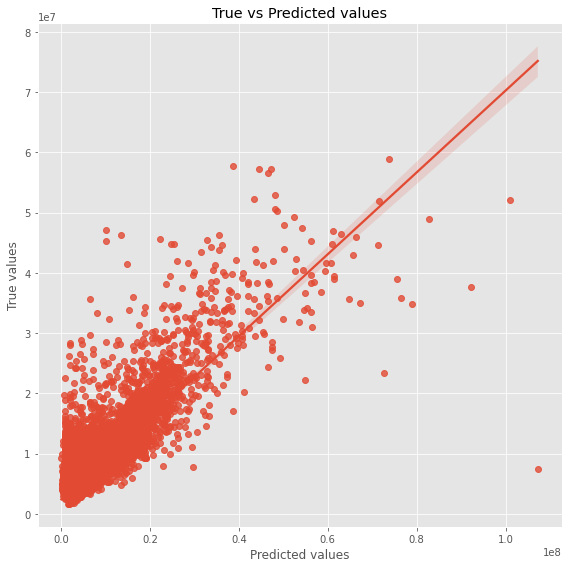

In [683]:
evaluate_preds(y, oof_preds_cat)

In [684]:
stability = create_bootstrap_metrics(y, oof_preds_cat, rmsle)

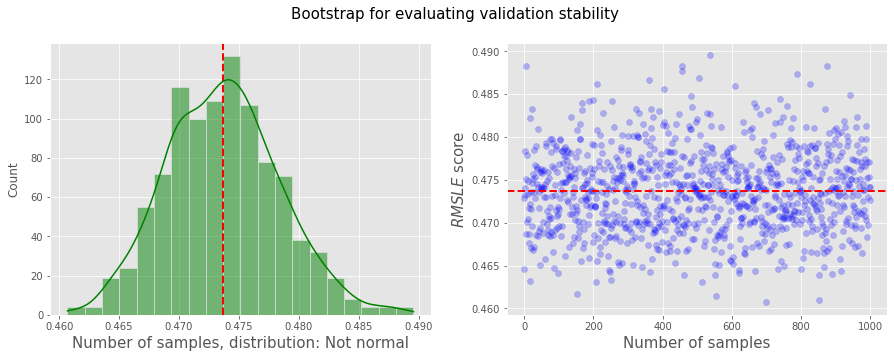

In [685]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle("Bootstrap for evaluating validation stability", size=15)
axes[1].scatter(range(len(stability)), stability, alpha=0.25, color="blue")
axes[1].set_xlabel("Number of samples", size=15)
axes[1].set_ylabel("$RMSLE$ score", size=15)
distribution = "Normal" if stats.shapiro(stability)[1] >= 0.05 else "Not normal"

axes[0].axvline(np.mean(stability), lw=2, ls='--', c='red')
axes[1].axhline(np.mean(stability), lw=2, ls='--', c='red')
sns.histplot(stability, ax=axes[0], color="green", bins=20, kde=True)
axes[0].set_xlabel(f"Number of samples, distribution: {distribution}", size=15)
plt.show()

In [686]:
# test_preds = np.array([model.predict(test) for model in estimators_cat]).T.mean(axis=1)
test_preds = estimators_cat[1].predict(test)

In [687]:
submission = pd.DataFrame(data={"id": test.index, TARGET: test_preds})
submission.to_csv("submission.csv", index=False)

In [688]:
!kaggle competitions submit -c sberbank-russian-housing-market -f submission.csv -m "Message"

Successfully submitted to Sberbank Russian Housing Market



  0%|          | 0.00/188k [00:00<?, ?B/s]
100%|##########| 188k/188k [00:01<00:00, 105kB/s]


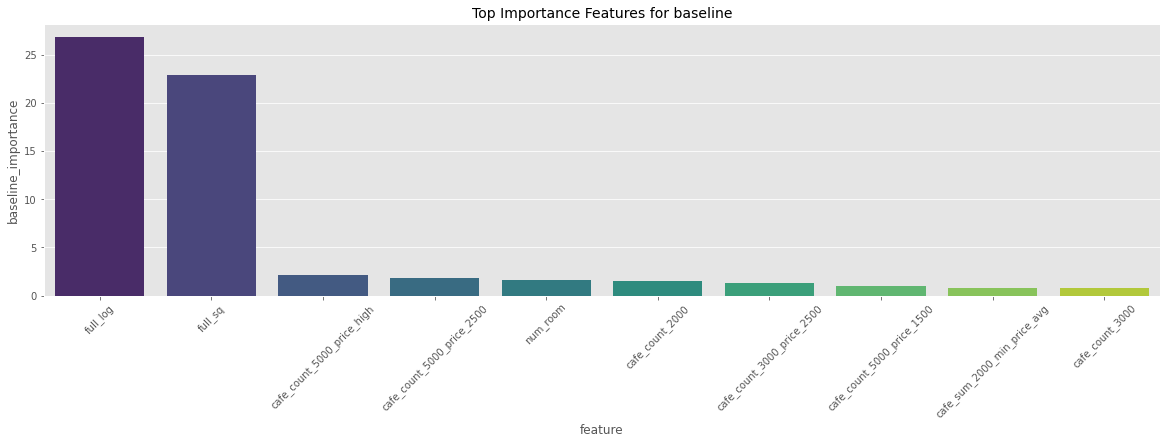

In [689]:
importance = pd.DataFrame({
    "feature": X.columns,
    "baseline_importance": estimators_cat[1].get_feature_importance()
})
importance = importance.sort_values(by="baseline_importance", ascending=False)
importance = importance.head(n=10)

plt.figure(figsize=(20, 5))
sns.barplot(x=importance["feature"], y=importance["baseline_importance"], palette="viridis")
plt.title("Top Importance Features for baseline", size=14)
plt.xticks(rotation=45)
plt.show()

**XGBoost**

In [1170]:
train, test = df[~df[TARGET].isna()], df[df[TARGET].isna()].drop(TARGET, axis=1)
X, y = train.drop(TARGET, axis=1).reset_index(drop=True), train[TARGET].reset_index(drop=True)

In [1171]:
xgb_params = {
            'eta': 0.05,
            'max_depth': 8,
            'subsample': 0.7,
            'colsample_bytree': 0.7,
            'objective': 'reg:squarederror',
            'eval_metric': 'rmsle',
            'verbosity': 0,
            'min_child_weight': 56,
            'reg_lambda': 10,
            'gamma': 4
}

In [1173]:
%%time
xgb_estimators, encoders, oof_xgb_score = xgboost_cross_validation(xgb_params,
                                                                   X[perm],
                                                                   y,
                                                                   cv=KFold(n_splits=7, shuffle=True, random_state=seed),
                                                                   categorical=perm_cat,
                                                                   rounds=None,
                                                                   num_boost_rounds=420)
gc.collect()

Tue Sep 13 23:10:44 2022, Cross-Validation, 30397 rows, 64 cols
Fold 1, Train score = 0.42182, Valid score = 0.48390
Fold 2, Train score = 0.41686, Valid score = 0.50559
Fold 3, Train score = 0.42026, Valid score = 0.48714
Fold 4, Train score = 0.42160, Valid score = 0.48765
Fold 5, Train score = 0.42164, Valid score = 0.47209
Fold 6, Train score = 0.41944, Valid score = 0.49758
Fold 7, Train score = 0.42184, Valid score = 0.48349
Train score by each fold: [0.42182, 0.41686, 0.42026, 0.4216, 0.42164, 0.41944, 0.42184]
Valid score by each fold: [0.4839, 0.50559, 0.48714, 0.48765, 0.47209, 0.49758, 0.48349]
Train mean score by each fold:0.42049 +/- 0.00171
Valid mean score by each fold:0.48821 +/- 0.00994
**************************************************
OOF-score: 0.48831
CPU times: total: 15min 55s
Wall time: 1min 3s


107

In [1176]:
test_preds = []
for encoder, model in zip(encoders, xgb_estimators):
    test2 = test[perm].copy(deep=True)
    test2[perm_cat] = encoder.transform(test2[perm_cat])
    preds = model.predict(xgb.DMatrix(test2))
    test_preds.append(preds)
test_preds = np.array(test_preds).T.mean(axis=1)

R2:	0.672
MAE:	1389152.024
RMSE:	2524315.731
MSE:	6372169912013.817

RMSLE:	0.48831


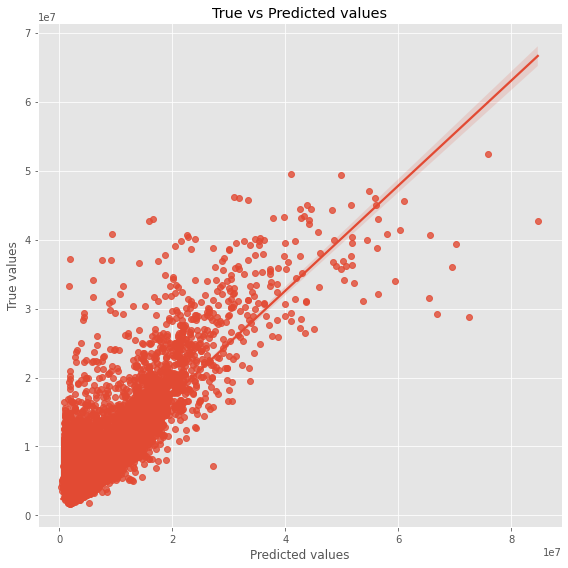

In [1174]:
evaluate_preds(y, oof_xgb_score)

In [1178]:
# 0.32086
submission = pd.DataFrame(data={"id": test.index, TARGET: test_preds})
submission.to_csv("submission.csv", index=False)
!kaggle competitions submit -c sberbank-russian-housing-market -f submission.csv -m "Message"

Successfully submitted to Sberbank Russian Housing Market



  0%|          | 0.00/128k [00:00<?, ?B/s]
  6%|6         | 8.00k/128k [00:00<00:01, 81.8kB/s]
100%|##########| 128k/128k [00:02<00:00, 65.1kB/s] 


**XGBoost with boruta**

In [1196]:
xgb_params = {
            'eta': 0.05,
            'max_depth': 10,
            'subsample': 0.7,
            'colsample_bytree': 0.55,
            'objective': 'reg:squarederror',
            'eval_metric': 'rmsle',
            'verbosity': 0,
            'min_child_weight': 56,
            'reg_lambda': 10,
            'gamma': 4
}

In [1197]:
%%time
xgb_estimators2, encoders2, oof_xgb_score2 = xgboost_cross_validation(xgb_params,
                                                                      X[boruta],
                                                                      (y / multipliers[2]) * multipliers[3],
                                                                      cv=KFold(n_splits=7, shuffle=True, random_state=seed),
                                                                      categorical=boruta_cat,
                                                                      rounds=None,
                                                                      num_boost_rounds=482)
gc.collect()

Tue Sep 13 23:29:29 2022, Cross-Validation, 30397 rows, 114 cols
Fold 1, Train score = 0.39371, Valid score = 0.47960
Fold 2, Train score = 0.38884, Valid score = 0.50417
Fold 3, Train score = 0.38929, Valid score = 0.48421
Fold 4, Train score = 0.39261, Valid score = 0.48742
Fold 5, Train score = 0.39349, Valid score = 0.47001
Fold 6, Train score = 0.39205, Valid score = 0.49228
Fold 7, Train score = 0.39307, Valid score = 0.47873
Train score by each fold: [0.39371, 0.38884, 0.38929, 0.39261, 0.39349, 0.39205, 0.39307]
Valid score by each fold: [0.4796, 0.50417, 0.48421, 0.48742, 0.47001, 0.49228, 0.47873]
Train mean score by each fold:0.39187 +/- 0.00185
Valid mean score by each fold:0.48520 +/- 0.01014
**************************************************
OOF-score: 0.48531
CPU times: total: 28min 18s
Wall time: 1min 53s


3340

R2:	0.666
MAE:	1410700.655
RMSE:	2511622.554
MSE:	6308247852089.654

RMSLE:	0.48531


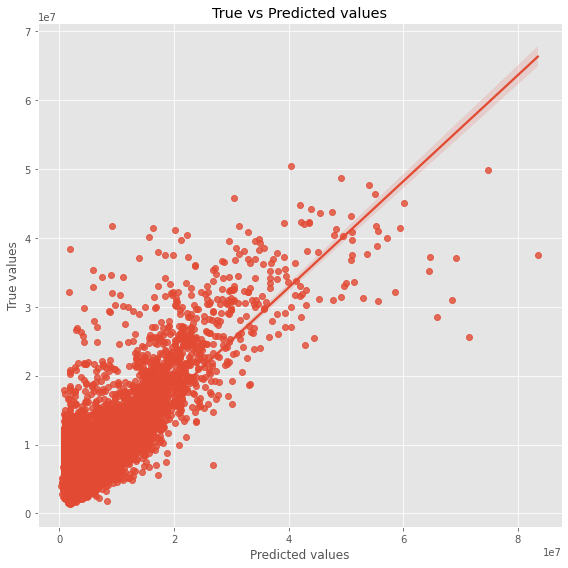

In [1198]:
evaluate_preds((y / multipliers[2]) * multipliers[3], oof_xgb_score2)

In [1199]:
test_preds2 = []
for encoder, model in zip(encoders2, xgb_estimators2):
    test2 = test[boruta].copy(deep=True)
    test2[boruta_cat] = encoder.transform(test2[boruta_cat])
    preds = model.predict(xgb.DMatrix(test2))
    test_preds2.append(preds)
test_preds2 = np.array(test_preds2).T.mean(axis=1)

In [1200]:
# 0.32327
submission = pd.DataFrame(data={"id": test.index, TARGET: test_preds2})
submission.to_csv("submission.csv", index=False)
!kaggle competitions submit -c sberbank-russian-housing-market -f submission.csv -m "Message"

Successfully submitted to Sberbank Russian Housing Market



  0%|          | 0.00/128k [00:00<?, ?B/s]
100%|##########| 128k/128k [00:01<00:00, 75.7kB/s]


**Select From model with locations**

In [1270]:
xgb_params = {
            'eta': 0.05,
            'max_depth': 6,
            'subsample': 0.7,
            'colsample_bytree': 0.55,
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'verbosity': 0,
            'min_child_weight': 56,
            'reg_lambda': 10,
            'gamma': 4
}

In [1271]:
%%time
xgb_estimators3, encoders3, oof_xgb_score3 = xgboost_cross_validation(xgb_params,
                                                                      X[from_model],
                                                                      y + 10,
                                                                      cv=KFold(n_splits=7, shuffle=True, random_state=seed),
                                                                      categorical=from_model_cat,
                                                                      rounds=None,
                                                                      num_boost_rounds=389)
gc.collect()

Wed Sep 14 00:37:59 2022, Cross-Validation, 30397 rows, 126 cols
Fold 1, Train score = 0.43546, Valid score = 0.47931
Fold 2, Train score = 0.43079, Valid score = 0.50775
Fold 3, Train score = 0.43418, Valid score = 0.48491
Fold 4, Train score = 0.43471, Valid score = 0.49071
Fold 5, Train score = 0.43502, Valid score = 0.47216
Fold 6, Train score = 0.43228, Valid score = 0.49782
Fold 7, Train score = 0.43394, Valid score = 0.48705
Train score by each fold: [0.43546, 0.43079, 0.43418, 0.43471, 0.43502, 0.43228, 0.43394]
Valid score by each fold: [0.47931, 0.50775, 0.48491, 0.49071, 0.47216, 0.49782, 0.48705]
Train mean score by each fold:0.43377 +/- 0.00154
Valid mean score by each fold:0.48853 +/- 0.01088
**************************************************
OOF-score: 0.48865
CPU times: total: 13min 37s
Wall time: 54.9 s


2585

R2:	0.665
MAE:	1395109.756
RMSE:	2552210.356
MSE:	6513777699414.483

RMSLE:	0.48865


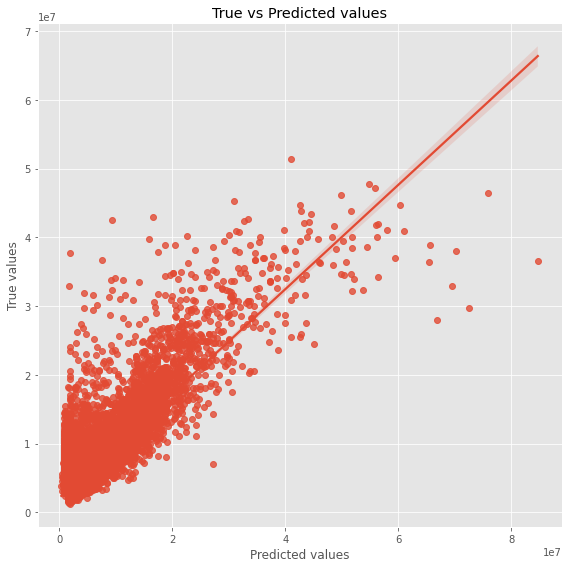

In [1272]:
evaluate_preds(y + 10, oof_xgb_score3)

In [1273]:
test_preds3 = []
for encoder, model in zip(encoders3, xgb_estimators3):
    test2 = test[from_model].copy(deep=True)
    test2[from_model_cat] = encoder.transform(test2[from_model_cat])
    preds = model.predict(xgb.DMatrix(test2))
    test_preds3.append(preds)
test_preds3 = np.array(test_preds3).T.mean(axis=1)

In [1274]:
# 0.32227
submission = pd.DataFrame(data={"id": test.index, TARGET: test_preds3})
submission.to_csv("submission.csv", index=False)
!kaggle competitions submit -c sberbank-russian-housing-market -f submission.csv -m "Message"

Successfully submitted to Sberbank Russian Housing Market



  0%|          | 0.00/128k [00:00<?, ?B/s]
100%|##########| 128k/128k [00:01<00:00, 70.7kB/s]


**Permutation+Boruta features with log target**

In [1307]:
xgb_params = {
            'eta': 0.05,
            'max_depth': 5,
            'subsample': 0.7,
            'colsample_bytree': 0.55,
            'objective': 'reg:squarederror',
            'eval_metric': 'rmsle',
            'verbosity': 0,
            'min_child_weight': 56,
            'reg_lambda': 10,
            'gamma': 4
}

In [1283]:
mix = list(set(perm) & set(boruta))
mix_cat = [col for col in mix if X[col].dtype in ["object", "category"]]

In [1308]:
%%time
xgb_estimators4, encoders4, oof_xgb_score4 = xgboost_cross_validation(xgb_params,
                                                                      X[mix],
                                                                      np.log(y),
                                                                      cv=KFold(n_splits=7, shuffle=True, random_state=seed),
                                                                      categorical=mix_cat,
                                                                      rounds=None,
                                                                      num_boost_rounds=499)
gc.collect()

Wed Sep 14 00:58:09 2022, Cross-Validation, 30397 rows, 45 cols
Fold 1, Train score = 0.02758, Valid score = 0.02986
Fold 2, Train score = 0.02738, Valid score = 0.03113
Fold 3, Train score = 0.02758, Valid score = 0.02948
Fold 4, Train score = 0.02760, Valid score = 0.02956
Fold 5, Train score = 0.02756, Valid score = 0.02884
Fold 6, Train score = 0.02748, Valid score = 0.03026
Fold 7, Train score = 0.02743, Valid score = 0.02953
Train score by each fold: [0.02758, 0.02738, 0.02758, 0.0276, 0.02756, 0.02748, 0.02743]
Valid score by each fold: [0.02986, 0.03113, 0.02948, 0.02956, 0.02884, 0.03026, 0.02953]
Train mean score by each fold:0.02752 +/- 0.00008
Valid mean score by each fold:0.02981 +/- 0.00067
**************************************************
OOF-score: 0.02982
CPU times: total: 8min 40s
Wall time: 37.7 s


3085

R2:	0.665
MAE:	1489979.992
RMSE:	2550288.508
MSE:	6503971475564.532

RMSLE:	0.47633


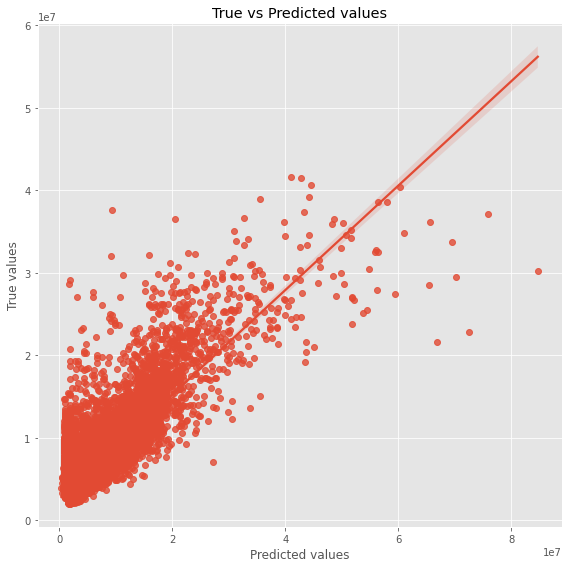

In [1309]:
evaluate_preds(y, np.exp(oof_xgb_score4))

In [1310]:
test_preds4 = []
for encoder, model in zip(encoders4, xgb_estimators4):
    test2 = test[mix].copy(deep=True)
    test2[mix_cat] = encoder.transform(test2[mix_cat])
    preds = model.predict(xgb.DMatrix(test2))
    test_preds4.append(np.exp(preds))
test_preds4 = np.array(test_preds4).T.mean(axis=1)

In [1311]:
# 0.33042
submission = pd.DataFrame(data={"id": test.index, TARGET: test_preds4})
submission.to_csv("submission.csv", index=False)
!kaggle competitions submit -c sberbank-russian-housing-market -f submission.csv -m "Message"

Successfully submitted to Sberbank Russian Housing Market



  0%|          | 0.00/128k [00:00<?, ?B/s]
100%|##########| 128k/128k [00:01<00:00, 68.2kB/s]


**Aggregating results**

In [1317]:
oof_predictions = pd.DataFrame(data={'m1': oof_xgb_score, 'm2': oof_xgb_score2, 'm3': oof_xgb_score3, 
                                     'm4': np.exp(oof_xgb_score4)
                                    })

In [1322]:
test_predictions = pd.DataFrame(data={'m1': test_preds, 'm2': test_preds2, 'm3': test_preds3, 
                                      'm4': test_preds4
                                     })

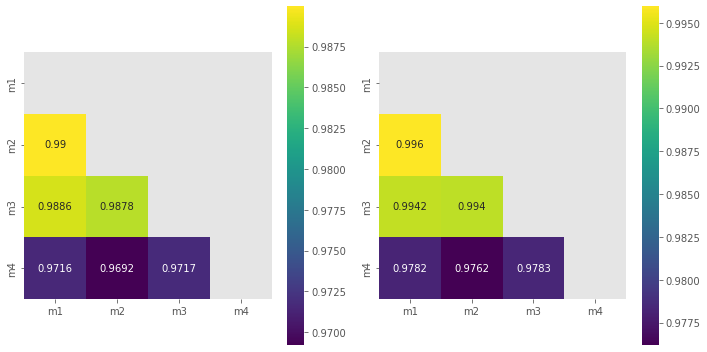

In [1329]:
corr = oof_predictions.corr()
corr2 = test_predictions.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes = axes.flatten()
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes[0])
sns.heatmap(corr2, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes[1])
plt.tight_layout()
plt.show()

In [ ]:
# amean, gmean not working
# Ridge, Random Forest no working

In [1333]:
from scipy.optimize import minimize

results_list = []   
weights_list = []  
preds = oof_predictions.values

def weights_objective(weights):
    y_ens = np.average(preds, axis=1, weights=weights)
    # y_ens = stats.gmean(preds, axis=1, weights=weights)
    return rmsle(y, y_ens)

for k in range(100):
  
    w0 = np.random.uniform(size=preds.shape[1])
    bounds = [(0,1)] * preds.shape[1]

    cons = [{'type': 'eq',
             'fun': lambda w: w.sum() - 1}]

    res = minimize(weights_objective,
                   w0,
                   method='SLSQP',
                   bounds=bounds,
                   options={'disp': False, 'maxiter': 10000},
                   constraints=cons)

    results_list.append(res.fun)
    weights_list.append(res.x)

best_score = np.min(results_list)    
best_weights = weights_list[results_list.index(best_score)]

print('\nOptimized weights:')
print('Best score: {:.4f}'.format(best_score))


Optimized weights:
Best score: 0.4755


In [1432]:
agg_preds = np.average(test_predictions, axis=1)  #  0.32063

In [1376]:
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

# y transforms: coef? 
ridge = Ridge(alpha=0.01,
              normalize=False,
              solver="svd",
              random_state=seed)

pipe = make_pipeline(StandardScaler(),
                     PCA(n_components=None, random_state=seed), 
                     ridge)

rf = RandomForestRegressor(n_estimators=200, max_depth=5, max_features=4, n_jobs=-1, random_state=seed)

estimators_ridge, oof_preds_ridge, mean_score_ridge = cross_validation(model=rf,
                                                                       X=oof_predictions,
                                                                       y=y,
                                                                       cv=KFold(n_splits=10, shuffle=True, random_state=seed))
gc.collect()

Fold 1, Train score: 0.46802, Valid score = 0.46191
Fold 2, Train score: 0.46582, Valid score = 0.48390
Fold 3, Train score: 0.46595, Valid score = 0.48172
Fold 4, Train score: 0.46704, Valid score = 0.47201
Fold 5, Train score: 0.46742, Valid score = 0.46762
Fold 6, Train score: 0.46797, Valid score = 0.46090
Fold 7, Train score: 0.46915, Valid score = 0.44866
Fold 8, Train score: 0.46621, Valid score = 0.48141
Fold 9, Train score: 0.46693, Valid score = 0.47525
Fold 10, Train score: 0.46767, Valid score = 0.46867
Train score by each fold: [0.46802, 0.46582, 0.46595, 0.46704, 0.46742, 0.46797, 0.46915, 0.46621, 0.46693, 0.46767]
Valid score by each fold: [0.46191, 0.4839, 0.48172, 0.47201, 0.46762, 0.4609, 0.44866, 0.48141, 0.47525, 0.46867]
Train mean score by each fold:0.46722 +/- 0.00099
Valid mean score by each fold:0.47021 +/- 0.01050
**************************************************


312

In [1377]:
agg_preds = np.array([estimator.predict(test_predictions) for estimator in estimators_ridge]).T
agg_preds = pd.DataFrame(data=agg_preds)
agg_preds = np.average(agg_preds, axis=1)

In [1383]:
agg_preds = pd.DataFrame()
agg_preds["m1_m2"] = np.exp( .714*np.log(test_predictions.m1) + .286*np.log(test_predictions.m2))

agg_preds["m1_m2_m3"] = np.exp( .714*np.log(agg_preds.m1_m2) + .286*np.log(test_predictions.m3))
agg_preds["m1_m2_m3_m4"] = np.exp( .714*np.log(agg_preds.m1_m2_m3) + .286*np.log(test_predictions.m4))
agg_preds = agg_preds["m1_m2_m3_m4"] * 0.9915
# 0.32123

In [1393]:
agg_preds = pd.DataFrame()
agg_preds["m2_m1"] = np.exp( .714*np.log(test_predictions.m2) + .286*np.log(test_predictions.m1))

agg_preds["m1_m2_m3"] = np.exp( .714*np.log(agg_preds.m2_m1) + .286*np.log(test_predictions.m3))
agg_preds["m1_m2_m3_m4"] = np.exp( .714*np.log(agg_preds.m1_m2_m3) + .286*np.log(test_predictions.m4))
agg_preds = agg_preds["m1_m2_m3_m4"] * 0.995
# 0.32188

In [1394]:
submission = pd.DataFrame(data={"id": test.index, TARGET: agg_preds})
submission.to_csv("submission.csv", index=False)
!kaggle competitions submit -c sberbank-russian-housing-market -f submission.csv -m "Message"

Successfully submitted to Sberbank Russian Housing Market



  0%|          | 0.00/128k [00:00<?, ?B/s]
100%|##########| 128k/128k [00:01<00:00, 90.6kB/s]


* For now best private: 0.32063, obtained by simple arythmetic mean averaging of 4 sets of models

### Draw Results

In [1710]:
grouped_areas = pd.concat([X, y], axis=1).groupby("sub_area").agg({TARGET: "mean", "latitude": "max", "longitude": "max"})

In [1559]:
no_names = ['Аэропорт', 'Академическое', 'Алтуфьевское', 'Бабушкинское',
           'Беговая', 'Бескудниковская', 'Восточное Бирюлево', 'Бутырская',
           'Черемушки', 'Южное Чертаново', 'Гольяново', 'Хорошево-Мневники',
           'Хорошевское', 'Ярославское', 'Южное Бутово', 'Южное Медведково',
           'Южное Тушино', 'Южнопортовая', 'Капотня', 'Коньково',
           'Красносельская', 'Крюково', 'Кузьминки', 'Левобережная',
           'Марьина Роща', 'Мещанская', 'Молжаниновская',
           'Москворечье-Сабурово', 'Можайское', 'Нижегородское', 'Обруческое',
           'Орехово-Борисово Южное', 'Поселение Десеновское',
           'Поселение Марушкинское', 'Поселение Михайлово-Ярцевсвское',
           'Поселение Рязановское', 'Поселение Щаповское',
           'Поселение Щербинка', 'Рязанский', 'Щукино', 'Сокольники',
           'Соколиная Гора', 'Старое Крюково', 'Таганская', 'Текстильщики',
           'Тимирязевское', 'Вешняки', 'Войковская', 'Восточное',
           'Восточное Дегунино', 'Восточное Измайлово', 'Замоскворечье',
           'Зябликово', 'Зюзино']

In [1562]:
nan_locations = {}
for no_name, name in zip(no_names, grouped_areas[grouped_areas["latitude"].isna()].index):

    url = 'https://nominatim.openstreetmap.org/search/' + urllib.parse.quote(f"Москва {no_name}") +'?format=json'
    response = requests.get(url).json()
    if response:
        nan_locations[name] = [response[0]["lat"], response[0]["lon"]]
    else:
        # nan_locations[name] = [np.nan, np.nan]
        continue
locations.update(nan_locations)  # take initial locations from appendix

In [1711]:
grouped_areas.reset_index(inplace=True)

grouped_areas["latitude"] = grouped_areas.reset_index()["sub_area"].apply(lambda x: locations[x][0]).astype("float")
grouped_areas["longitude"] = grouped_areas.reset_index()["sub_area"].apply(lambda x: locations[x][1]).astype("float")

In [1712]:
df_pred = pd.concat([test["sub_area"].reset_index(), pd.Series(agg_preds, name="preds")], axis=1).groupby("sub_area").agg({"preds": "mean"})

In [1713]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
import h3

moscow_lon = 37.618423
moscow_lat = 55.751244

crs = {'init' :'epsg:4326'}
geometry = [Point(xy) for xy in zip(grouped_areas.longitude, grouped_areas.latitude)]

geo_df = gpd.GeoDataFrame(data={TARGET: grouped_areas[TARGET], 
                                "sub_area": grouped_areas["sub_area"],
                                "lon": grouped_areas["longitude"],
                                "lat": grouped_areas["latitude"]}, geometry=geometry, crs=crs)

geo_df = geo_df.merge(df_pred, on="sub_area", how="left")

In [1714]:
geo_df2 = gpd.GeoDataFrame(data={TARGET: grouped_areas[TARGET], 
                                 "lon": grouped_areas["longitude"],
                                 "lat": grouped_areas["latitude"]}, geometry=geometry, crs=crs)

In [1715]:
h3_res = 7

def geo_to_h3(row):
    return h3.geo_to_h3(lat=row.lat, lng=row.lon, resolution=h3_res)

In [1716]:
geo_df['hex'] = geo_df.apply(geo_to_h3, axis=1)
geo_df.dropna(inplace=True)

In [1717]:
def add_geometry(row):
    points = h3.h3_to_geo_boundary(row['hex'], True)
    return Polygon(points)

geo_df['geometry'] = geo_df.apply(add_geometry, axis=1)

In [1718]:
import folium
from folium import Choropleth, Circle, Marker

In [1737]:
moscow = folium.Map(location=[moscow_lat, moscow_lon], tiles='cartodbpositron', zoom_start=12)

In [1738]:
Choropleth(geo_data=geo_df.__geo_interface__, 
           data=geo_df[TARGET], 
           key_on="feature.id", 
           fill_color='YlGnBu', 
           legend_name='Moscow Appartment prices 2011-2015'
          ).add_to(moscow)

Choropleth(geo_data=geo_df.__geo_interface__, 
           data=geo_df["preds"], 
           key_on="feature.id", 
           fill_color='YlGnBu', 
           legend_name='Moscow Appartment prices 2015-2016 predicted'
          ).add_to(moscow)

In [1739]:
from geojson import Feature, Point, FeatureCollection
import json
import matplotlib

In [1740]:
new_map = choropleth_map(geo_df, column_name=TARGET, initial_map=moscow)

Colour column min value 2632468.545456797, max value 18678324.708622854, mean value 7195945.997649755
Hexagon cell count: 125


In [1741]:
def color_producer(val):
    if val <= 5000000:
        return 'forestgreen'
    else:
        return 'darkred'

for i in range(len(geo_df)):
    html = f'Old prices mean: {geo_df[TARGET].iloc[i]:.2f}<br>Predicted mean: {geo_df["preds"].iloc[i]:.2f}'

    iframe = folium.IFrame(html, width=300, height=55)
    popup = folium.Popup(iframe, max_width=400)

    marker = folium.Circle([geo_df["lat"].iloc[i], geo_df["lon"].iloc[i]], popup=popup, 
                           radius=30, 
                           color=color_producer(geo_df["preds"].iloc[i])).add_to(new_map)

In [ ]:
new_map

In [1745]:
from folium.plugins import MarkerCluster

moscow2 = folium.Map(location=[moscow_lat, moscow_lon], tiles='cartodbpositron', zoom_start=12)

mc = MarkerCluster()
for idx, row in geo_df.iterrows():
    html = f'Old prices mean: {geo_df[TARGET].loc[idx]:.2f}<br>Predicted mean: {geo_df["preds"].loc[idx]:.2f}'

    iframe = folium.IFrame(html, width=300, height=55)
    popup = folium.Popup(iframe, max_width=400)
    
    mc.add_child(Marker([row['lat'], row['lon']], popup=popup))
moscow2.add_child(mc)

moscow2

In [1746]:
moscow2.save('moscow_map.html') 

### Appendix

**Lets try to select features**

In [1095]:
x_train, x_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.3, random_state=seed)

for feature in cat_cols:
    encoder = ce.cat_boost.CatBoostEncoder(random_state=seed)
    x_train[feature] = encoder.fit_transform(x_train[feature], y_train)
    x_test[feature] = encoder.transform(x_test[feature])

estimator = xgb.XGBRegressor(**xgb_params).fit(x_train, y_train)


scores, deltas = calculate_permutation_importance(estimator, rmsle, x_test, y_test, maximize=False)

100%|████████████████████████████████████████████████████████████████████████████████| 455/455 [00:30<00:00, 14.77it/s]


In [1100]:
perm = deltas[deltas > 1e-4].index.tolist()

In [ ]:
perm = ['full_sq', 'full_log', 'sub_area', 'mean_sq_met_price', 'floor', 'build_year', 'life_sq', 'max_floor', 'num_room', 
        'ttk_km', 'cafe_count_5000_price_2500', 'build_year_cut', 'product_type', 'cafe_count_5000', 
        'cafe_count_5000_price_high', 'year_diff', 'life_log', 'cafe_count_1000', 'power_transmission_line_km',
        'culture_objects_top_25', 'kitchen_full_ratio', 'kitch_sq', 'sadovoe_km', 'ecology', 'FULL_SQ_MEAN_BY_STATE_SUB_AREA',
        'office_sqm_5000', 'cafe_count_500_price_1500', 'NUM_ROOM_MEAN_BY_STATE_SUB_AREA', 'green_zone_km', 
        'NUM_ROOM_MEAN_BY_SUB_AREA', 'KITCH_SQ_STD_BY_STATE_SUB_AREA', 'fitness_km', 'railroad_km', 
        'cafe_sum_2000_min_price_avg', 'state', 'office_sqm_500', 'shopping_centers_density', 'cafe_count_3000_price_500', 
        'LIFE_SQ_COUNT_BY_SUB_AREA', 'indust_part', 'university_km', 'metro_km_avto', 'big_market_km', 
        'LIFE_SQ_MEAN_BY_STATE_SUB_AREA', 'swim_pool_km', 'radiation_raion', 'NUM_ROOM_MEAN_BY_STATE_MATERIAL',
        'radiation_km', 'hospital_beds_raion', 'raion_build_count_with_material_info', 'square_per_trc_1500',
        'office_sqm_1500', 'trc_count_3000', 'big_road1_importance', 'metro_min_avto', 'green_part_500', 
        'seat_per_preschool_center', 'congestion_metro', 'big_road2_importance', 'public_healthcare_km',
        'cafe_avg_price_2000', 'theater_km', 'railroad_station_walk_km', 'square_per_trc_3000']

perm_cat = [col for col in perm if X[col].dtype in ["object", "category"]]

In [1106]:
selector = BorutaShap(model=xgb.XGBRegressor(**xgb_params), importance_measure='shap', classification=False)
selector.fit(pd.concat([x_train, x_test]), pd.concat([y_train, y_test]), n_trials=20, sample=False, normalize=True, verbose=True)

Warning there are missing values in your data !


  0%|          | 0/20 [00:00<?, ?it/s]

114 attributes confirmed important: ['year', 'incineration_raion', 'bulvar_ring_km', 'cafe_count_1500_price_1500', 'swim_pool_km', 'oil_chemistry_km', 'power_transmission_line_km', 'shopping_centers_km', 'cafe_count_2000', 'detention_facility_raion', 'nuclear_reactor_raion', 'preschool_km', 'railroad_km', 'cafe_count_1500_price_high', 'big_road2_importance', 'prom_part_1500', 'cafe_count_1000_price_1500', 'FULL_SQ_MEAN_BY_STATE_MATERIAL', 'culture_objects_top_25', 'cafe_count_5000', 'water_1line', 'exhibition_km', 'year_diff', 'sub_area', 'cafe_sum_5000_max_price_avg', 'trc_sqm_1500', 'LIFE_SQ_MEAN_BY_STATE_SUB_AREA', 'church_count_3000', 'life_sq', 'fitness_km', 'NUM_ROOM_MEAN_BY_SUB_AREA', 'sadovoe_km', 'big_church_km', 'big_road1_km', 'additional_education_km', 'green_zone_km', 'public_transport_station_km', 'cafe_count_2000_price_1000', 'cafe_count_5000_na_price', 'FULL_SQ_COUNT_BY_STATE_SUB_AREA', 'big_market_raion', 'radiation_km', 'office_sqm_5000', 'green_part_1500', 'green_par

In [1109]:
boruta = ['year', 'incineration_raion', 'bulvar_ring_km', 'cafe_count_1500_price_1500', 'swim_pool_km', 'oil_chemistry_km', 
          'power_transmission_line_km', 'shopping_centers_km', 'cafe_count_2000', 'detention_facility_raion', 
          'nuclear_reactor_raion', 'preschool_km', 'railroad_km', 'cafe_count_1500_price_high', 'big_road2_importance', 
          'prom_part_1500', 'cafe_count_1000_price_1500', 'FULL_SQ_MEAN_BY_STATE_MATERIAL', 'culture_objects_top_25', 
          'cafe_count_5000', 'water_1line', 'exhibition_km', 'year_diff', 'sub_area', 'cafe_sum_5000_max_price_avg', 
          'trc_sqm_1500', 'LIFE_SQ_MEAN_BY_STATE_SUB_AREA', 'church_count_3000', 'life_sq', 'fitness_km', 
          'NUM_ROOM_MEAN_BY_SUB_AREA', 'sadovoe_km', 'big_church_km', 'big_road1_km', 'additional_education_km', 
          'green_zone_km', 'public_transport_station_km', 'cafe_count_2000_price_1000', 'cafe_count_5000_na_price', 
          'FULL_SQ_COUNT_BY_STATE_SUB_AREA', 'big_market_raion', 'radiation_km', 'office_sqm_5000', 'green_part_1500', 
          'green_part_5000', 'kitchen_full_ratio', 'university_km', 'office_count_1000', 'school_km', 'product_type', 
          'nuclear_reactor_km', 'public_healthcare_km', 'room_size', 'square_per_trc_1500', 'NUM_ROOM_MEAN_BY_STATE_MATERIAL', 
          'cafe_count_1000', 'life_log', 'ecology', 'mosque_km', 'FULL_SQ_MEAN_BY_STATE_SUB_AREA', 'radiation_raion', 
          'FULL_SQ_STD_BY_STATE_SUB_AREA', 'mean_sq_met_price', 'cafe_count_2000_price_2500', 'metro_km_avto', 
          'trc_count_2000', 'cafe_count_5000_price_2500', 'LIFE_SQ_COUNT_BY_STATE_SUB_AREA', 'theater_km', 'railroad_1line', 
          'leisure_count_3000', 'cafe_count_3000_price_4000', 'office_count_3000', 'build_year', 'hospital_beds_raion', 
          'railroad_terminal_raion', 'num_room', 'thermal_power_plant_raion', 'year_month', 'state', 'cafe_count_3000', 
          'church_count_5000', 'build_year_cut', 'weekday', 'prom_part_1000', 'max_floor', 'stadium_km', 
          'KITCH_SQ_MEDIAN_BY_SUB_AREA', 'cafe_count_1000_price_high', 'kremlin_km', 'zd_vokzaly_avto_km', 
          'NUM_ROOM_STD_BY_STATE_MATERIAL', 'build_count_brick', 'square_per_office_500', 'metro_min_walk', 
          'big_road1_1line', 'park_km', 'cafe_count_5000_price_high', 'life_sq_full_ratio', 'full_log', 'square_per_trc_5000', 
          'NUM_ROOM_MEAN_BY_STATE_SUB_AREA', 'kitch_sq', 'kindergarten_km', 'full_sq', 'industrial_km', 'sport_count_3000', 
          'cafe_count_3000_price_1500', 'seat_per_school_center', 'ttk_km', 'floor', 'oil_chemistry_raion', 'metro_min_avto', 
          'cafe_count_5000_price_1500']

boruta_cat = [col for col in boruta if X[col].dtype in ["object", "category"]]

**Get longitude and latitude features**

In [1212]:
import requests
import urllib.parse

locations = {}
for name in X["sub_area"].unique():

    url = 'https://nominatim.openstreetmap.org/search/' + urllib.parse.quote(f"Moscow {name}") +'?format=json'
    response = requests.get(url).json()
    if response:
        locations[name] = [response[0]["lat"], response[0]["lon"]]
    else:
        locations[name] = [np.nan, np.nan]

In [1218]:
X["latitude"] = X["sub_area"].apply(lambda x: locations[x][0]).astype(float)
X["longitude"] = X["sub_area"].apply(lambda x: locations[x][1]).astype(float)

test["latitude"] = test["sub_area"].apply(lambda x: locations[x][0]).astype(float)
test["longitude"] = test["sub_area"].apply(lambda x: locations[x][1]).astype(float)

X["lon_lat_ratio"] = X["latitude"] / X["longitude"]
test["lon_lat_ratio"] = test["latitude"] / test["longitude"]

**Generic feature selection**

In [1241]:
from sklearn.feature_selection import GenericUnivariateSelect, mutual_info_regression

x_train, x_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.3, random_state=seed)

for feature in cat_cols:
    encoder = ce.cat_boost.CatBoostEncoder(random_state=seed)
    x_train[feature] = encoder.fit_transform(x_train[feature], y_train)
    x_test[feature] = encoder.transform(x_test[feature])

transformer = GenericUnivariateSelect(mutual_info_regression, 
                                      mode='k_best', 
                                      param=100).fit(pd.concat([x_train, x_test]).fillna(-9999), 
                                                    pd.concat([y_train, y_test]))

In [1242]:
generic = X.columns[list(transformer.get_support(True))]

In [1244]:
generic = ['full_sq', 'life_sq', 'max_floor', 'num_room', 'kitch_sq', 'product_type', 'area_m', 'raion_popul', 
           'green_zone_part', 'indust_part', 'children_preschool', 'children_school', 'full_all', 'male_f', 'female_f', 
           'young_all', 'young_male', 'young_female', 'work_all', 'work_male', 'work_female', 'ekder_all', 'ekder_male',
           'ekder_female', '0_6_all', '0_6_male', '0_6_female', '7_14_all', '7_14_male', '7_14_female', '0_17_all', 
           '0_17_male', '0_17_female', '16_29_all', '16_29_male', '16_29_female', '0_13_all', '0_13_male', '0_13_female', 
           'ID_railroad_station_avto', 'ttk_km', 'sadovoe_km', 'bulvar_ring_km', 'kremlin_km', 'zd_vokzaly_avto_km',
           'oil_chemistry_km', 'nuclear_reactor_km', 'basketball_km', 'detention_facility_km', 'ecology', 'trc_sqm_5000', 
           'month_year_cnt', 'week_year_cnt', 'kitchen_full_ratio', 'full_log', 'life_log', 'build_year_cut', 'room_size', 
           'pop_density', 'schools_density', 'female_ratio', 'male_ratio', 'male_female_ratio_area', 
           'male_female_ratio_district', 'young_ratio', 'young_female_ratio', 'young_male_ratio', 'work_ratio', 
           'work_female_ratio', 'work_male_ratio', 'children_burden', 'ekder_ratio', 'ekder_female_ratio', 'ekder_male_ratio', 
           'FULL_SQ_MEAN_BY_SUB_AREA', 'FULL_SQ_MAX_BY_SUB_AREA', 'FULL_SQ_COUNT_BY_SUB_AREA', 'FULL_SQ_STD_BY_SUB_AREA', 
           'FULL_SQ_SUM_BY_SUB_AREA', 'KITCH_SQ_MEAN_BY_SUB_AREA', 'KITCH_SQ_COUNT_BY_SUB_AREA', 'KITCH_SQ_SUM_BY_SUB_AREA', 
           'LIFE_SQ_MEAN_BY_SUB_AREA', 'LIFE_SQ_MAX_BY_SUB_AREA', 'LIFE_SQ_COUNT_BY_SUB_AREA', 'LIFE_SQ_STD_BY_SUB_AREA', 
           'LIFE_SQ_SUM_BY_SUB_AREA', 'LIFE_SQ_MEDIAN_BY_SUB_AREA', 'NUM_ROOM_MEAN_BY_SUB_AREA', 'NUM_ROOM_COUNT_BY_SUB_AREA', 
           'NUM_ROOM_SUM_BY_SUB_AREA', 'MAX_FLOOR_MEAN_BY_SUB_AREA', 'KITCH_SQ_MEAN_BY_STATE_SUB_AREA', 
           'LIFE_SQ_MEAN_BY_STATE_SUB_AREA', 'LIFE_SQ_MEDIAN_BY_STATE_SUB_AREA', 'KITCH_SQ_MEAN_BY_STATE_MATERIAL', 
           'KITCH_SQ_STD_BY_STATE_MATERIAL', 'LIFE_SQ_MEAN_BY_STATE_MATERIAL', 'LIFE_SQ_MEDIAN_BY_STATE_MATERIAL',
           'mean_sq_met_price']

generic_cat = [col for col in generic if X[col].dtype in ["object", "category"]]

**Select From model**

In [1262]:
from sklearn.linear_model import Lasso

model_selector = SelectFromModel(estimator=Lasso(normalize=True, 
                                                 alpha=100,
                                                 random_state=seed), 
                                 threshold=1e-5,).fit(pd.concat([x_train, x_test]).fillna(-1), 
                                                      pd.concat([y_train, y_test]))

In [1263]:
from_model = X.columns[list(model_selector.get_support(True))]

In [1269]:
from_model = ['full_sq', 'life_sq', 'floor', 'max_floor', 'num_room', 'kitch_sq', 'state', 'product_type', 'sub_area',
              'school_education_centers_raion', 'school_education_centers_top_20_raion', 'healthcare_centers_raion', 
              'culture_objects_top_25', 'radiation_raion', 'big_market_raion', 'build_count_frame', 'build_count_monolith', 
              'build_count_mix', 'ID_metro', 'metro_min_avto', 'metro_km_avto', 'kindergarten_km', 'park_km', 'green_zone_km', 
              'industrial_km', 'cemetery_km', 'ID_railroad_station_avto', 'public_transport_station_km', 'big_road1_1line', 
              'ID_big_road2', 'railroad_1line', 'zd_vokzaly_avto_km', 'nuclear_reactor_km', 'big_market_km', 'market_shop_km', 
              'ice_rink_km', 'public_healthcare_km', 'university_km', 'church_synagogue_km', 'mosque_km', 'theater_km',
              'ecology', 'prom_part_500', 'office_count_500', 'office_sqm_500', 'trc_sqm_500', 'cafe_count_500_price_1000',
              'cafe_count_500_price_2500', 'cafe_count_500_price_4000', 'cafe_count_500_price_high', 'church_count_500', 
              'leisure_count_500', 'green_part_1000', 'prom_part_1000', 'office_count_1000', 'office_sqm_1000', 
              'cafe_sum_1000_max_price_avg', 'cafe_count_1000_price_1000', 'cafe_count_1000_price_4000', 
              'cafe_count_1000_price_high', 'leisure_count_1000', 'market_count_1000', 'office_sqm_1500', 
              'cafe_sum_1500_min_price_avg', 'cafe_count_1500_price_high', 'mosque_count_1500', 'prom_part_2000', 
              'trc_sqm_2000', 'cafe_sum_2000_max_price_avg', 'big_church_count_2000', 'cafe_sum_3000_min_price_avg', 
              'mosque_count_3000', 'sport_count_3000', 'green_part_5000', 'prom_part_5000', 'office_sqm_5000', 
              'cafe_count_5000_price_high', 'market_count_5000', 'year_month', 'year', 'month', 'week_year_cnt', 
              'floor_to_max_ratio', 'year_diff', 'children_pre_ratio', 'kitchen_full_ratio', 'life_sq_full_ratio', 
              'build_year_cut', 'floors_diff', 'floors_ratio', 'sale_before_build', 'hospital_bed_density', 
              'best_university_ratio', 'good_bad_propotion', 'seat_per_school_center', 'male_ratio', 'young_male_ratio', 
              'on_sale_build_year_ratio', 'congestion_railroad', 'big_road2_importance', 'square_per_office_500',
              'square_per_trc_1000', 'square_per_office_3000', 'square_per_trc_5000', 'cafe_sum_500_diff', 
              'FULL_SQ_MEAN_BY_SUB_AREA', 'FULL_SQ_MIN_BY_SUB_AREA', 'KITCH_SQ_MEAN_BY_SUB_AREA', 'KITCH_SQ_SUM_BY_SUB_AREA',
              'KITCH_SQ_MEDIAN_BY_SUB_AREA', 'LIFE_SQ_MAX_BY_SUB_AREA', 'NUM_ROOM_MEAN_BY_SUB_AREA', 
              'NUM_ROOM_MEDIAN_BY_SUB_AREA', 'FULL_SQ_MEAN_BY_STATE_SUB_AREA', 'FULL_SQ_MIN_BY_STATE_SUB_AREA',
              'FULL_SQ_STD_BY_STATE_SUB_AREA', 'FULL_SQ_MEDIAN_BY_STATE_SUB_AREA', 'KITCH_SQ_MAX_BY_STATE_SUB_AREA',
              'KITCH_SQ_COUNT_BY_STATE_SUB_AREA', 'LIFE_SQ_MAX_BY_STATE_SUB_AREA', 'MAX_FLOOR_MAX_BY_STATE_SUB_AREA',
              'KITCH_SQ_MAX_BY_STATE_MATERIAL', 'LIFE_SQ_COUNT_BY_STATE_MATERIAL', 'NUM_ROOM_MIN_BY_STATE_MATERIAL',
              'NUM_ROOM_COUNT_BY_STATE_MATERIAL', 'mean_sq_met_price']

from_model_cat = [col for col in from_model if X[col].dtype in ["object", "category"]]

### Appendix 2

In [1422]:
cb_params = {
            "iterations": 422,
            "learning_rate": 0.01,
            "loss_function": "RMSE",
            "eval_metric": "MSLE",
            "task_type": "CPU",
            "max_bin": 30,
            "silent": True,
            "depth": 3,
            "l2_leaf_reg": 100,
            "thread_count": -1,
            "random_seed": seed,
            "allow_writing_files": False,
            "subsample": 0.7, 
            "max_ctr_complexity": 2,
            "grow_policy": "SymmetricTree",
            "boosting_type": "Ordered",  
            "score_function": "Cosine", 
            "bootstrap_type": "MVS",  
            "bagging_temperature": 1, 
            "colsample_bylevel": 0.55,
            "use_best_model": True,
}

In [1426]:
fold = KFold(n_splits=5, random_state=seed, shuffle=True)
cb_x = X[perm].copy(deep=True)
cb_x[perm_cat] = cb_x[perm_cat].astype("str").astype("category")

cat_estim, oof_preds = catboost_cross_validation(cb_params, 
                                                 cb_x[perm], 
                                                 np.clip(np.log(y), 0, np.percentile(y, 99)), 
                                                 cv=fold, 
                                                 rounds=None,
                                                 categorical=perm_cat,
                                                )
gc.collect()

Wed Sep 14 12:51:16 2022, Cross-Validation, 30397 rows, 64 cols
Fold 1, Train score = 0.02951, Valid score = 0.02984
Fold 2, Train score = 0.02949, Valid score = 0.02986
Fold 3, Train score = 0.02959, Valid score = 0.02943
Fold 4, Train score = 0.02962, Valid score = 0.02937
Fold 5, Train score = 0.02952, Valid score = 0.02958
Train score by each fold: [0.02951, 0.02949, 0.02959, 0.02962, 0.02952]
Valid score by each fold: [0.02984, 0.02986, 0.02943, 0.02937, 0.02958]
Train mean score by each fold:0.02955 +/- 0.00005
Valid mean score by each fold:0.02962 +/- 0.00020
**************************************************
OOF-score: 0.02962


3291

In [1431]:
calculate_confidence_interval(create_bootstrap_metrics(np.exp(np.clip(np.log(y), 0, np.percentile(y, 99))), np.exp(oof_preds), 
                                                       rmsle))

(0.4671294500088007, 0.4825158089636901)

In [1427]:
agg_preds = np.array([np.exp(model.predict(test2)) for model in cat_estim]).T.mean(axis=1)

In [1429]:
# poor result
submission = pd.DataFrame(data={"id": test.index, TARGET: agg_preds})
submission.to_csv("submission.csv", index=False)
!kaggle competitions submit -c sberbank-russian-housing-market -f submission.csv -m "Message"

Successfully submitted to Sberbank Russian Housing Market



  0%|          | 0.00/188k [00:00<?, ?B/s]
100%|##########| 188k/188k [00:01<00:00, 104kB/s]


In [1414]:
cb_params = {
            "iterations": 452,
            "learning_rate": 0.01,
            "loss_function": "RMSE",
            "eval_metric": "MSLE",
            "task_type": "CPU",
            "max_bin": 30,
            "verbose": 50,
            "depth": 3,
            "l2_leaf_reg": 100,
            "thread_count": -1,
            "random_seed": seed,
            "allow_writing_files": False,
            "subsample": 0.7, 
            "max_ctr_complexity": 2,
            "grow_policy": "SymmetricTree",
            "boosting_type": "Ordered",  
            "score_function": "Cosine", 
            "bootstrap_type": "MVS",  
            "bagging_temperature": 1, 
            "colsample_bylevel": 0.55,
}

In [1416]:
cat = CatBoostRegressor(cat_features=perm_cat, **cb_params).fit(cb_x[perm], y, plot=False)

0:	learn: 0.3895456	total: 47.1ms	remaining: 21.3s
50:	learn: 0.3186819	total: 3.71s	remaining: 29.1s
100:	learn: 0.2867533	total: 7.5s	remaining: 26.1s
150:	learn: 0.2694504	total: 11.4s	remaining: 22.7s
200:	learn: 0.2600206	total: 15.2s	remaining: 19s
250:	learn: 0.2539105	total: 19s	remaining: 15.2s
300:	learn: 0.2496284	total: 22.9s	remaining: 11.5s
350:	learn: 0.2458548	total: 26.8s	remaining: 7.7s
400:	learn: 0.2433121	total: 30.6s	remaining: 3.89s
450:	learn: 0.2409394	total: 34.4s	remaining: 76.3ms
451:	learn: 0.2408283	total: 34.5s	remaining: 0us


In [1417]:
test2 = test[perm].copy(deep=True)
test2[perm_cat] = test2[perm_cat].astype("str").astype("category")

agg_preds = catboost.CatBoost.predict(cat, test2, prediction_type="RawFormulaVal")

In [1419]:
# poor result
submission = pd.DataFrame(data={"id": test.index, TARGET: agg_preds})
submission.to_csv("submission.csv", index=False)
!kaggle competitions submit -c sberbank-russian-housing-market -f submission.csv -m "Message"

Successfully submitted to Sberbank Russian Housing Market



  0%|          | 0.00/188k [00:00<?, ?B/s]
100%|##########| 188k/188k [00:01<00:00, 103kB/s]


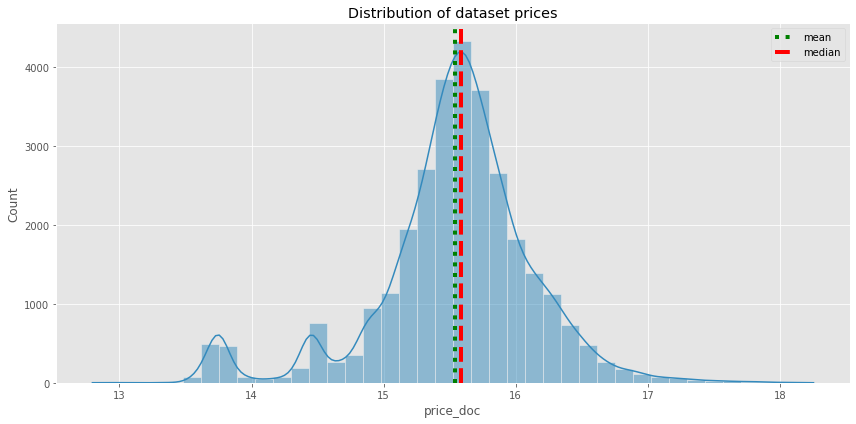

In [1420]:
plt.figure(figsize = (12, 6))
func = lambda x: np.clip(np.log(x), 0,  np.percentile(train[TARGET], 99.7))

sns.histplot(y.apply(func), bins=40, kde=True)
plt.axvline(y.apply(func).mean(), label='mean', linestyle=':', color='green', linewidth=4)
plt.axvline(y.apply(func).median(), label='median', linestyle='--', color='red', linewidth=4)

plt.title('Distribution of dataset prices')
plt.legend()
plt.tight_layout()
plt.show()